# MLP with embiddings

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
from copy import deepcopy
import random
import time

# Set random seed to ensure reproducability and some global variables.
# However, for pytorch, it is not perfectly reproducable. The results may vary
# between different software and hardware platform.
seed = 88888
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)
random.seed(a=seed)
g = torch.Generator()
g.manual_seed(seed)
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")


# Drop null value in target columns. 
target = 'HadHeartAttack'
df = pd.read_csv("heart_2022_with_nans.csv").dropna(subset=target)
# Seperate the features and the target
X = df.drop(columns=target)
y = df[target]
categoryFeatures = X.select_dtypes(include='object').columns.tolist()
numericalFeatures = X.select_dtypes(exclude='object').columns.tolist()
# Rearrange columns by categorical features and numerical features
X = X[categoryFeatures + numericalFeatures]
# Split train dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
    )
# Fill categorical features with mode. Fill numercial features with means.
for col in categoryFeatures:
    fill = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(fill)
    X_test[col] = X_test[col].fillna(fill)
for col in numericalFeatures:
    fill = X_train[col].mean()
    X_train[col] = X_train[col].fillna(fill)
    X_test[col] = X_test[col].fillna(fill)

# Use oridnal encoder to encode categorical features for following process of embedding layers.
# Use standardscaler to standardize numerical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('categories', OrdinalEncoder(), categoryFeatures),
        ('numberics', StandardScaler(), numericalFeatures)
    ]
)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
# Mapping 'yes' and 'no' in target to 1 and 0
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# Recording number of classes for each categorical features
featuresClasses = []
for i in range(len(categoryFeatures)):
    featuresClasses.append(len(
        preprocessor.named_transformers_['categories'].categories_[i]
        ))
# Recording number of categorical features for numpy array split
length = len(categoryFeatures)         

In [2]:
# Transform numpy array to torch tensors and create torch dataset.
X_train_categories = torch.tensor(X_train[:,0:length], dtype=torch.long)
X_train_numerics = torch.tensor(X_train[:,length:], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_categories = torch.tensor(X_test[:,0:length], dtype=torch.long)
X_test_numerics = torch.tensor(X_test[:,length:], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
train_ds = TensorDataset(X_train_categories, X_train_numerics, y_train_tensor)
test_ds = TensorDataset(X_test_categories, X_test_numerics, y_test_tensor)

In [3]:
# Define a class to stop training when it detects that training is leading to overfitting.
class EarlyStopping:
    def __init__(self, patience, mode='max'):
        # Set some class attribute to record
        self.patience = patience
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model = None
        self.best_probs = None

    def __call__(self, model, probs, score):
        # Use deepcopy to store copies of the instances
        if self.best_score is None:
            self.best_model = deepcopy(model)
            self.best_probs = deepcopy(probs)
            self.best_score = deepcopy(score)
        else:
            if self.mode == 'max':
                improve = score - self.best_score > 0
            else:
                improve = self.best_score - score > 0
            if improve:
                self.best_model = deepcopy(model)
                self.best_probs = deepcopy(probs)
                self.best_score = deepcopy(score)
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

# Define the structure of neurol network
class EmbiddingMLP(nn.Module):
    # Leave some hyperparameters for tuning.
    def __init__(self, featuresClasses, num_layers, hidden_dim, dropout):
        super().__init__()
        # Define embedding layers
        self.embeddings = nn.ModuleList()
        total_embeddings_dimension = 0
        # Add embedding layers for categorical features to ensure classes in 
        # different categorical features have distinct vector representers.
        for i in featuresClasses:
            embedding = nn.Embedding(
                # Input dimension of embedding layers, which equals to number of classes
                num_embeddings=i, 
                # Output dimension of embedding layers. The follwing equation 
                # is according to others' experience in the application.
                embedding_dim=min(50, (i + 1) // 2)
                )
            self.embeddings.append(embedding)
            total_embeddings_dimension += embedding.embedding_dim
        layers = []
        # Make the number of hidden layers adjustable
        for i in range(num_layers):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                # Normalize output, mitigate over-fitting.
                nn.BatchNorm1d(hidden_dim),
                # ReLU is non-linear activation function, which is core of hidden layers to
                # capture non-linear relationship of dataset.
                nn.ReLU(),
                # Drop some neuron output to mitigate over-fitting
                nn.Dropout(dropout)
                ])
        # Define the actual structure
        self.model = nn.Sequential(
            nn.Linear(total_embeddings_dimension+len(numericalFeatures), hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            # Unpack hidden layers into model structure
            *layers,
            # Full connection layer to output result
            nn.Linear(hidden_dim, 1),
        )
    
    # Define the forward propagation process. 
    def forward(self, X_categories, X_numerics):
        # Get the result of embidding layers
        embidding_outputs = []
        for i in range(len(self.embeddings)):
            output = self.embeddings[i](X_categories[:, i])
            embidding_outputs.append(output)
        # Restructure embidding layers to a vector
        categoryFeaturesVector = torch.cat(embidding_outputs, dim=1)
        # Concatenate result of embidding layers and numerical features
        x = torch.cat([categoryFeaturesVector, X_numerics], dim=1)
        # Put into model for propagation
        return self.model(x)

In [4]:
# Define a train function to reuse in optuna and train final model
def trainMLP(batch_size, num_layers, hidden_dim, dropout, pos_weight, lr):
    # Define pytorch datalodaer
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=g)
    test_loader = DataLoader(test_ds, batch_size=batch_size)
    # Instantiate EmbiddingMLP model, and sent it to GPU when available
    model = EmbiddingMLP(
        featuresClasses=featuresClasses, 
        num_layers=num_layers, 
        hidden_dim=hidden_dim, 
        dropout=dropout
        ).to(device)
    # Set weight to mitigate imbalanced target.
    pos_weight = torch.tensor([pos_weight], device=device)
    # Use BCEWithLogitsLoss as loss function, which is suitable for binary classification
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Specify optimizer. Optimizer is a algorithm to update model parameters to minimize 
    # loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Instantiate early stopper. When there are no improvement in eval function, stop the
    # training.
    early_stopper = EarlyStopping(patience=10, mode='max')
    # Train the neurol network
    for epoch in range(200):
        start_time = time.time()
        # Set model to train mode
        model.train()
        # Record loss for batches
        total_loss = 0
        # Feed model in batches
        for xcb, xnb, yb in train_loader:
            # Sent batches to GPU when available.
            xcb, xnb, yb = xcb.to(device), xnb.to(device), yb.to(device)
            # Get the logits of forward propagation.
            logits = model(xcb, xnb)
            # Use loss function to calculate losses.
            loss = criterion(logits, yb)
            # Clean optimizer's gradient record.
            optimizer.zero_grad()
            # Back-propagation and calculate gradient
            loss.backward()
            # Use optimizer to update parameters.
            optimizer.step()
            # Record loss for the batches
            total_loss += loss.item()
        # Get average losses
        avg_loss = total_loss/ len(train_loader)
        # Set model to evaluate mode
        model.eval()
        logits = []
        # Tell model not to calculate and record gradient
        with torch.no_grad():
            for xcb, xnb, yb in test_loader:
                xcb, xnb, yb = xcb.to(device), xnb.to(device), yb.to(device)
                logits.append(model(xcb, xnb))
            logits = torch.cat(logits, dim=0)
        # Use sigmoid to get probability
        probs = torch.sigmoid(logits).cpu().numpy().squeeze()
        # Calculate the average precision score, i.e., the area under the PR curve. 
        score = average_precision_score(y_test, probs) 
        end_time = time.time()
        # Print verbose
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Score: {score:.4f}, {end_time - start_time:.2f}', flush=True)
        # Use early stopper to check improvement and detect overfitting
        early_stopper(model,probs,score)
        if early_stopper.early_stop:
            print(f'Early stopping triggered at epoch {epoch+1} with score {early_stopper.best_score}', flush=True)
            break
    # Restore model, probs, score from best epoch
    model = deepcopy(early_stopper.best_model)
    probs = deepcopy(early_stopper.best_probs)
    score = deepcopy(early_stopper.best_score)
    # Return model, probs, score to external
    return model, probs, score

In [5]:
# Optuna is a lib for tunining hyperparametres
import optuna
# Define random seed for optuna
sampler=optuna.samplers.TPESampler(seed=seed)
# Tuning function required by optuna
def objective(trial):
    # How much records being feeded into model each time
    batch_size = trial.suggest_int('batch_size', 2048, 16384)
    # Number of hidden layers
    num_layers = trial.suggest_int('num_layers', 1, 4)
    # Dimension of hidden layers, i.e., neurons.
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    # How many portion of neurons being dropped to avoid over-fitting.
    dropout = trial.suggest_float('dropout', 0, 0.5)
    # Set wights to handle imbalanced target.
    pos_weight = trial.suggest_float('pos_weight', 0.1, 10)
    # Set learning rate.
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Use hyperparameters to train model and get score. Do not need model and probs during tunning.
    _, _, score = trainMLP(
        batch_size=batch_size,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout=dropout,
        pos_weight=pos_weight,
        lr=lr
        )
    return score

# Create study instance
study = optuna.create_study(direction='maximize', sampler=sampler)
# Set 50 trials
study.optimize(objective, n_trials=50)

[I 2025-04-27 10:50:20,378] A new study created in memory with name: no-name-5db481f8-99f3-40c0-a6a4-bdfd3d06105b


Epoch 1, Loss: 0.6790, Score: 0.3665, 4.55
Epoch 2, Loss: 0.5806, Score: 0.3821, 4.04
Epoch 3, Loss: 0.5688, Score: 0.3956, 4.03
Epoch 4, Loss: 0.5560, Score: 0.3959, 3.89
Epoch 5, Loss: 0.5518, Score: 0.4003, 3.87
Epoch 6, Loss: 0.5402, Score: 0.3989, 3.73
Epoch 7, Loss: 0.5348, Score: 0.3934, 3.87
Epoch 8, Loss: 0.5281, Score: 0.3920, 6.87
Epoch 9, Loss: 0.5189, Score: 0.3926, 4.29
Epoch 10, Loss: 0.5103, Score: 0.3851, 4.31
Epoch 11, Loss: 0.5046, Score: 0.3868, 4.18
Epoch 12, Loss: 0.4923, Score: 0.3835, 4.06
Epoch 13, Loss: 0.4787, Score: 0.3785, 4.00
Epoch 14, Loss: 0.4726, Score: 0.3771, 3.88
Epoch 15, Loss: 0.4560, Score: 0.3708, 6.26
Early stopping triggered at epoch 15 with score 0.4002749097540519


[I 2025-04-27 10:51:27,194] Trial 0 finished with value: 0.4002749097540519 and parameters: {'batch_size': 11752, 'num_layers': 3, 'hidden_dim': 244, 'dropout': 0.04213331221293243, 'pos_weight': 8.74413412241151, 'lr': 0.0018026806292713597}. Best is trial 0 with value: 0.4002749097540519.


Epoch 1, Loss: 0.6209, Score: 0.3904, 4.06
Epoch 2, Loss: 0.4935, Score: 0.3937, 4.15
Epoch 3, Loss: 0.4907, Score: 0.3947, 4.15
Epoch 4, Loss: 0.4912, Score: 0.4004, 4.07
Epoch 5, Loss: 0.4886, Score: 0.4019, 4.13
Epoch 6, Loss: 0.4843, Score: 0.4040, 4.15
Epoch 7, Loss: 0.4844, Score: 0.4060, 4.12
Epoch 8, Loss: 0.4843, Score: 0.4046, 6.55
Epoch 9, Loss: 0.4804, Score: 0.4044, 4.11
Epoch 10, Loss: 0.4800, Score: 0.4062, 4.13
Epoch 11, Loss: 0.4793, Score: 0.4055, 4.21
Epoch 12, Loss: 0.4800, Score: 0.4051, 4.04
Epoch 13, Loss: 0.4741, Score: 0.4051, 4.03
Epoch 14, Loss: 0.4708, Score: 0.4044, 4.03
Epoch 15, Loss: 0.4707, Score: 0.4053, 4.08
Epoch 16, Loss: 0.4663, Score: 0.4036, 6.63
Epoch 17, Loss: 0.4671, Score: 0.4036, 4.02
Epoch 18, Loss: 0.4657, Score: 0.4009, 4.01
Epoch 19, Loss: 0.4623, Score: 0.3997, 4.10
Epoch 20, Loss: 0.4608, Score: 0.3991, 4.04
Early stopping triggered at epoch 20 with score 0.4061534098168669


[I 2025-04-27 10:52:54,051] Trial 1 finished with value: 0.4061534098168669 and parameters: {'batch_size': 7670, 'num_layers': 2, 'hidden_dim': 155, 'dropout': 0.11407749102618359, 'pos_weight': 6.534265434574544, 'lr': 0.09168560024705988}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.7809, Score: 0.3396, 3.61
Epoch 2, Loss: 0.5783, Score: 0.3888, 3.67
Epoch 3, Loss: 0.5637, Score: 0.3960, 3.78
Epoch 4, Loss: 0.5582, Score: 0.3970, 6.85
Epoch 5, Loss: 0.5567, Score: 0.3931, 3.83
Epoch 6, Loss: 0.5547, Score: 0.3971, 3.88
Epoch 7, Loss: 0.5529, Score: 0.3982, 3.88
Epoch 8, Loss: 0.5517, Score: 0.3965, 3.82
Epoch 9, Loss: 0.5497, Score: 0.3976, 3.83
Epoch 10, Loss: 0.5468, Score: 0.4010, 3.91
Epoch 11, Loss: 0.5436, Score: 0.4002, 3.91
Epoch 12, Loss: 0.5402, Score: 0.4014, 3.91
Epoch 13, Loss: 0.5391, Score: 0.4017, 6.73
Epoch 14, Loss: 0.5341, Score: 0.3997, 4.01
Epoch 15, Loss: 0.5309, Score: 0.4017, 3.84
Epoch 16, Loss: 0.5285, Score: 0.4004, 3.71
Epoch 17, Loss: 0.5245, Score: 0.4013, 3.91
Epoch 18, Loss: 0.5187, Score: 0.3985, 3.92
Epoch 19, Loss: 0.5126, Score: 0.3978, 3.84
Epoch 20, Loss: 0.5107, Score: 0.3992, 3.81
Epoch 21, Loss: 0.5033, Score: 0.3970, 6.62
Epoch 22, Loss: 0.4979, Score: 0.3951, 3.81
Epoch 23, Loss: 0.4903, Score: 0.3973, 3.

[I 2025-04-27 10:54:38,600] Trial 2 finished with value: 0.4016904717242311 and parameters: {'batch_size': 15660, 'num_layers': 2, 'hidden_dim': 318, 'dropout': 0.2348771706186737, 'pos_weight': 8.356689133103602, 'lr': 0.024038723647221268}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.7586, Score: 0.0757, 4.01
Epoch 2, Loss: 0.7371, Score: 0.1108, 3.93
Epoch 3, Loss: 0.7181, Score: 0.1392, 4.09
Epoch 4, Loss: 0.7000, Score: 0.1597, 7.09
Epoch 5, Loss: 0.6846, Score: 0.1745, 4.18
Epoch 6, Loss: 0.6708, Score: 0.1858, 4.17
Epoch 7, Loss: 0.6571, Score: 0.1946, 4.14
Epoch 8, Loss: 0.6440, Score: 0.2018, 4.17
Epoch 9, Loss: 0.6316, Score: 0.2081, 4.21
Epoch 10, Loss: 0.6207, Score: 0.2136, 4.09
Epoch 11, Loss: 0.6082, Score: 0.2190, 4.21
Epoch 12, Loss: 0.5975, Score: 0.2237, 7.15
Epoch 13, Loss: 0.5874, Score: 0.2280, 4.06
Epoch 14, Loss: 0.5782, Score: 0.2321, 3.90
Epoch 15, Loss: 0.5681, Score: 0.2359, 3.89
Epoch 16, Loss: 0.5595, Score: 0.2396, 3.90
Epoch 17, Loss: 0.5523, Score: 0.2434, 4.00
Epoch 18, Loss: 0.5437, Score: 0.2469, 4.04
Epoch 19, Loss: 0.5360, Score: 0.2504, 3.87
Epoch 20, Loss: 0.5291, Score: 0.2538, 6.85
Epoch 21, Loss: 0.5214, Score: 0.2570, 3.95
Epoch 22, Loss: 0.5148, Score: 0.2602, 3.91
Epoch 23, Loss: 0.5090, Score: 0.2636, 3.

[I 2025-04-27 11:09:02,429] Trial 3 finished with value: 0.39661371801887796 and parameters: {'batch_size': 12539, 'num_layers': 2, 'hidden_dim': 225, 'dropout': 0.38839921269896, 'pos_weight': 3.095013497228866, 'lr': 1.3549549536589386e-05}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.4642, Score: 0.3745, 3.97
Epoch 2, Loss: 0.3116, Score: 0.3960, 4.05
Epoch 3, Loss: 0.3078, Score: 0.4000, 3.98
Epoch 4, Loss: 0.3070, Score: 0.4021, 3.99
Epoch 5, Loss: 0.3063, Score: 0.4032, 4.00
Epoch 6, Loss: 0.3060, Score: 0.4042, 4.02
Epoch 7, Loss: 0.3057, Score: 0.4050, 4.05
Epoch 8, Loss: 0.3042, Score: 0.4054, 6.74
Epoch 9, Loss: 0.3036, Score: 0.4052, 4.04
Epoch 10, Loss: 0.3030, Score: 0.4039, 4.15
Epoch 11, Loss: 0.3015, Score: 0.3994, 4.75
Epoch 12, Loss: 0.3012, Score: 0.4004, 4.12
Epoch 13, Loss: 0.2999, Score: 0.4016, 3.99
Epoch 14, Loss: 0.2982, Score: 0.4034, 3.99
Epoch 15, Loss: 0.2960, Score: 0.3989, 3.92
Epoch 16, Loss: 0.2956, Score: 0.3969, 7.04
Epoch 17, Loss: 0.2935, Score: 0.3957, 4.05
Epoch 18, Loss: 0.2915, Score: 0.3914, 4.03
Early stopping triggered at epoch 18 with score 0.4054103341213481


[I 2025-04-27 11:10:21,341] Trial 4 finished with value: 0.4054103341213481 and parameters: {'batch_size': 9649, 'num_layers': 1, 'hidden_dim': 352, 'dropout': 0.2571336434039621, 'pos_weight': 3.0146182286856784, 'lr': 0.05498180757351565}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.2764, Score: 0.3827, 4.84
Epoch 2, Loss: 0.1905, Score: 0.3944, 4.31
Epoch 3, Loss: 0.1868, Score: 0.3986, 4.25
Epoch 4, Loss: 0.1848, Score: 0.3997, 4.18
Epoch 5, Loss: 0.1838, Score: 0.4018, 4.39
Epoch 6, Loss: 0.1828, Score: 0.4023, 7.25
Epoch 7, Loss: 0.1817, Score: 0.4013, 4.16
Epoch 8, Loss: 0.1812, Score: 0.4038, 4.18
Epoch 9, Loss: 0.1801, Score: 0.4002, 4.22
Epoch 10, Loss: 0.1791, Score: 0.4013, 4.25
Epoch 11, Loss: 0.1782, Score: 0.4013, 4.11
Epoch 12, Loss: 0.1776, Score: 0.4007, 4.18
Epoch 13, Loss: 0.1763, Score: 0.3987, 7.10
Epoch 14, Loss: 0.1753, Score: 0.3966, 4.38
Epoch 15, Loss: 0.1741, Score: 0.3950, 4.20
Epoch 16, Loss: 0.1726, Score: 0.3933, 4.34
Epoch 17, Loss: 0.1714, Score: 0.3941, 4.32
Epoch 18, Loss: 0.1702, Score: 0.3907, 4.31
Early stopping triggered at epoch 18 with score 0.4037988934442512


[I 2025-04-27 11:11:44,359] Trial 5 finished with value: 0.4037988934442512 and parameters: {'batch_size': 8558, 'num_layers': 3, 'hidden_dim': 299, 'dropout': 0.4835750739286464, 'pos_weight': 1.3387826188178213, 'lr': 0.0021235700110882353}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.6945, Score: 0.3399, 4.57
Epoch 2, Loss: 0.5646, Score: 0.3574, 4.59
Epoch 3, Loss: 0.5226, Score: 0.3643, 7.48
Epoch 4, Loss: 0.5037, Score: 0.3671, 4.52
Epoch 5, Loss: 0.4923, Score: 0.3692, 4.65
Epoch 6, Loss: 0.4841, Score: 0.3731, 4.62
Epoch 7, Loss: 0.4787, Score: 0.3757, 4.44
Epoch 8, Loss: 0.4737, Score: 0.3771, 4.52
Epoch 9, Loss: 0.4710, Score: 0.3777, 4.64
Epoch 10, Loss: 0.4661, Score: 0.3792, 7.55
Epoch 11, Loss: 0.4633, Score: 0.3811, 4.63
Epoch 12, Loss: 0.4596, Score: 0.3828, 4.61
Epoch 13, Loss: 0.4570, Score: 0.3824, 4.61
Epoch 14, Loss: 0.4555, Score: 0.3836, 4.51
Epoch 15, Loss: 0.4516, Score: 0.3819, 4.60
Epoch 16, Loss: 0.4489, Score: 0.3830, 4.61
Epoch 17, Loss: 0.4461, Score: 0.3833, 7.27
Epoch 18, Loss: 0.4437, Score: 0.3841, 4.66
Epoch 19, Loss: 0.4408, Score: 0.3844, 4.50
Epoch 20, Loss: 0.4372, Score: 0.3837, 4.55
Epoch 21, Loss: 0.4349, Score: 0.3842, 4.56
Epoch 22, Loss: 0.4324, Score: 0.3837, 4.63
Epoch 23, Loss: 0.4317, Score: 0.3842, 4.

[I 2025-04-27 11:14:08,830] Trial 6 finished with value: 0.3844349177137001 and parameters: {'batch_size': 5422, 'num_layers': 4, 'hidden_dim': 455, 'dropout': 0.11748626540964774, 'pos_weight': 5.996899872692863, 'lr': 4.298113261249996e-05}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.6014, Score: 0.1201, 4.29
Epoch 2, Loss: 0.5233, Score: 0.1453, 7.09
Epoch 3, Loss: 0.4610, Score: 0.1598, 4.37
Epoch 4, Loss: 0.4093, Score: 0.1723, 4.31
Epoch 5, Loss: 0.3662, Score: 0.1816, 4.31
Epoch 6, Loss: 0.3308, Score: 0.1906, 4.60
Epoch 7, Loss: 0.3013, Score: 0.1985, 4.32
Epoch 8, Loss: 0.2767, Score: 0.2058, 4.40
Epoch 9, Loss: 0.2566, Score: 0.2123, 7.16
Epoch 10, Loss: 0.2398, Score: 0.2183, 4.56
Epoch 11, Loss: 0.2259, Score: 0.2245, 4.36
Epoch 12, Loss: 0.2142, Score: 0.2302, 4.54
Epoch 13, Loss: 0.2041, Score: 0.2360, 4.39
Epoch 14, Loss: 0.1958, Score: 0.2410, 4.36
Epoch 15, Loss: 0.1888, Score: 0.2461, 4.31
Epoch 16, Loss: 0.1828, Score: 0.2514, 7.15
Epoch 17, Loss: 0.1776, Score: 0.2565, 4.40
Epoch 18, Loss: 0.1730, Score: 0.2616, 4.41
Epoch 19, Loss: 0.1689, Score: 0.2664, 4.31
Epoch 20, Loss: 0.1654, Score: 0.2716, 4.32
Epoch 21, Loss: 0.1623, Score: 0.2772, 4.30
Epoch 22, Loss: 0.1594, Score: 0.2822, 4.35
Epoch 23, Loss: 0.1569, Score: 0.2877, 4.

[I 2025-04-27 11:24:35,606] Trial 7 finished with value: 0.3907732928662062 and parameters: {'batch_size': 5904, 'num_layers': 1, 'hidden_dim': 487, 'dropout': 0.35489164070783397, 'pos_weight': 0.7468463263634382, 'lr': 1.47791445714207e-05}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.9185, Score: 0.1835, 4.85
Epoch 2, Loss: 0.7931, Score: 0.2175, 4.81
Epoch 3, Loss: 0.7392, Score: 0.2461, 7.61
Epoch 4, Loss: 0.7056, Score: 0.2746, 4.82
Epoch 5, Loss: 0.6781, Score: 0.3001, 4.66
Epoch 6, Loss: 0.6579, Score: 0.3203, 4.75
Epoch 7, Loss: 0.6426, Score: 0.3388, 4.78
Epoch 8, Loss: 0.6294, Score: 0.3519, 4.76
Epoch 9, Loss: 0.6183, Score: 0.3620, 7.65
Epoch 10, Loss: 0.6097, Score: 0.3695, 4.75
Epoch 11, Loss: 0.6053, Score: 0.3743, 4.72
Epoch 12, Loss: 0.5999, Score: 0.3779, 4.77
Epoch 13, Loss: 0.5972, Score: 0.3812, 4.69
Epoch 14, Loss: 0.5942, Score: 0.3832, 4.76
Epoch 15, Loss: 0.5900, Score: 0.3849, 4.73
Epoch 16, Loss: 0.5871, Score: 0.3861, 7.65
Epoch 17, Loss: 0.5845, Score: 0.3866, 4.72
Epoch 18, Loss: 0.5840, Score: 0.3879, 4.72
Epoch 19, Loss: 0.5812, Score: 0.3880, 4.73
Epoch 20, Loss: 0.5802, Score: 0.3890, 4.68
Epoch 21, Loss: 0.5790, Score: 0.3895, 4.63
Epoch 22, Loss: 0.5760, Score: 0.3894, 4.57
Epoch 23, Loss: 0.5759, Score: 0.3907, 7.

[I 2025-04-27 11:30:07,105] Trial 8 finished with value: 0.3926886839450543 and parameters: {'batch_size': 4273, 'num_layers': 1, 'hidden_dim': 355, 'dropout': 0.4898403593227836, 'pos_weight': 8.827495422120965, 'lr': 3.939852372692558e-05}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.7865, Score: 0.1300, 4.42
Epoch 2, Loss: 0.7411, Score: 0.1532, 4.20
Epoch 3, Loss: 0.7023, Score: 0.1640, 4.18
Epoch 4, Loss: 0.6674, Score: 0.1709, 4.19
Epoch 5, Loss: 0.6357, Score: 0.1761, 4.11
Epoch 6, Loss: 0.6064, Score: 0.1805, 4.18
Epoch 7, Loss: 0.5798, Score: 0.1843, 4.20
Epoch 8, Loss: 0.5557, Score: 0.1874, 6.87
Epoch 9, Loss: 0.5333, Score: 0.1901, 4.13
Epoch 10, Loss: 0.5127, Score: 0.1932, 4.20
Epoch 11, Loss: 0.4945, Score: 0.1960, 4.21
Epoch 12, Loss: 0.4769, Score: 0.1984, 4.21
Epoch 13, Loss: 0.4613, Score: 0.2011, 4.21
Epoch 14, Loss: 0.4469, Score: 0.2041, 4.18
Epoch 15, Loss: 0.4333, Score: 0.2069, 7.12
Epoch 16, Loss: 0.4214, Score: 0.2099, 4.12
Epoch 17, Loss: 0.4098, Score: 0.2129, 4.25
Epoch 18, Loss: 0.3996, Score: 0.2163, 4.21
Epoch 19, Loss: 0.3902, Score: 0.2192, 4.23
Epoch 20, Loss: 0.3812, Score: 0.2229, 4.13
Epoch 21, Loss: 0.3734, Score: 0.2268, 4.17
Epoch 22, Loss: 0.3654, Score: 0.2304, 4.22
Epoch 23, Loss: 0.3581, Score: 0.2343, 7.

[I 2025-04-27 11:43:44,431] Trial 9 finished with value: 0.39161240544580106 and parameters: {'batch_size': 8702, 'num_layers': 3, 'hidden_dim': 465, 'dropout': 0.3721050156842455, 'pos_weight': 1.8431308581307364, 'lr': 1.1233103590300292e-05}. Best is trial 1 with value: 0.4061534098168669.


Epoch 1, Loss: 0.4875, Score: 0.3966, 4.39
Epoch 2, Loss: 0.4650, Score: 0.3990, 4.42
Epoch 3, Loss: 0.4627, Score: 0.4031, 4.59
Epoch 4, Loss: 0.4602, Score: 0.4026, 4.50
Epoch 5, Loss: 0.4578, Score: 0.4031, 7.47
Epoch 6, Loss: 0.4565, Score: 0.4068, 4.54
Epoch 7, Loss: 0.4546, Score: 0.4034, 4.56
Epoch 8, Loss: 0.4515, Score: 0.4018, 4.39
Epoch 9, Loss: 0.4476, Score: 0.3985, 4.40
Epoch 10, Loss: 0.4457, Score: 0.3989, 4.49
Epoch 11, Loss: 0.4418, Score: 0.4032, 4.43
Epoch 12, Loss: 0.4386, Score: 0.4016, 7.15
Epoch 13, Loss: 0.4340, Score: 0.3975, 4.54
Epoch 14, Loss: 0.4292, Score: 0.3953, 4.54
Epoch 15, Loss: 0.4235, Score: 0.3959, 4.53
Epoch 16, Loss: 0.4190, Score: 0.3944, 4.51
Early stopping triggered at epoch 16 with score 0.4067787464497168


[I 2025-04-27 11:45:01,907] Trial 10 finished with value: 0.4067787464497168 and parameters: {'batch_size': 2830, 'num_layers': 4, 'hidden_dim': 150, 'dropout': 0.006463626599129246, 'pos_weight': 5.9891288930174476, 'lr': 0.01358962504621936}. Best is trial 10 with value: 0.4067787464497168.


Epoch 1, Loss: 0.4948, Score: 0.3992, 4.36
Epoch 2, Loss: 0.4749, Score: 0.4050, 4.61
Epoch 3, Loss: 0.4718, Score: 0.4041, 7.41
Epoch 4, Loss: 0.4704, Score: 0.4052, 4.41
Epoch 5, Loss: 0.4677, Score: 0.4065, 4.54
Epoch 6, Loss: 0.4654, Score: 0.4059, 4.45
Epoch 7, Loss: 0.4626, Score: 0.4039, 4.32
Epoch 8, Loss: 0.4615, Score: 0.4010, 4.44
Epoch 9, Loss: 0.4578, Score: 0.4023, 4.35
Epoch 10, Loss: 0.4553, Score: 0.4015, 4.35
Epoch 11, Loss: 0.4521, Score: 0.4005, 7.21
Epoch 12, Loss: 0.4472, Score: 0.3975, 4.46
Epoch 13, Loss: 0.4438, Score: 0.3986, 4.50
Epoch 14, Loss: 0.4397, Score: 0.3960, 4.41
Epoch 15, Loss: 0.4349, Score: 0.3933, 4.47
Early stopping triggered at epoch 15 with score 0.40650716688541394


[I 2025-04-27 11:46:14,248] Trial 11 finished with value: 0.40650716688541394 and parameters: {'batch_size': 2607, 'num_layers': 4, 'hidden_dim': 159, 'dropout': 0.0033496792939517453, 'pos_weight': 6.1921476137807865, 'lr': 0.01041475365851661}. Best is trial 10 with value: 0.4067787464497168.


Epoch 1, Loss: 0.4446, Score: 0.3927, 4.48
Epoch 2, Loss: 0.4116, Score: 0.4009, 5.26
Epoch 3, Loss: 0.4091, Score: 0.4039, 7.64
Epoch 4, Loss: 0.4073, Score: 0.4032, 4.62
Epoch 5, Loss: 0.4053, Score: 0.4053, 4.53
Epoch 6, Loss: 0.4040, Score: 0.4063, 4.65
Epoch 7, Loss: 0.4020, Score: 0.4079, 4.76
Epoch 8, Loss: 0.3995, Score: 0.4069, 4.57
Epoch 9, Loss: 0.3964, Score: 0.4029, 4.64
Epoch 10, Loss: 0.3950, Score: 0.4035, 7.54
Epoch 11, Loss: 0.3915, Score: 0.4015, 4.62
Epoch 12, Loss: 0.3885, Score: 0.3980, 4.61
Epoch 13, Loss: 0.3841, Score: 0.3933, 4.48
Epoch 14, Loss: 0.3811, Score: 0.3957, 4.40
Epoch 15, Loss: 0.3767, Score: 0.3911, 4.40
Epoch 16, Loss: 0.3724, Score: 0.3890, 4.44
Epoch 17, Loss: 0.3684, Score: 0.3858, 7.32
Early stopping triggered at epoch 17 with score 0.4079369183489162


[I 2025-04-27 11:47:41,245] Trial 12 finished with value: 0.4079369183489162 and parameters: {'batch_size': 2261, 'num_layers': 4, 'hidden_dim': 140, 'dropout': 0.010792401783993353, 'pos_weight': 4.8549891184558325, 'lr': 0.008761381171686932}. Best is trial 12 with value: 0.4079369183489162.


Epoch 1, Loss: 0.4183, Score: 0.3886, 4.18
Epoch 2, Loss: 0.3912, Score: 0.4012, 4.30
Epoch 3, Loss: 0.3882, Score: 0.4020, 4.50
Epoch 4, Loss: 0.3871, Score: 0.4051, 4.24
Epoch 5, Loss: 0.3847, Score: 0.4057, 4.19
Epoch 6, Loss: 0.3841, Score: 0.4033, 4.19
Epoch 7, Loss: 0.3822, Score: 0.4051, 6.40
Epoch 8, Loss: 0.3805, Score: 0.4033, 4.26
Epoch 9, Loss: 0.3783, Score: 0.4044, 4.25
Epoch 10, Loss: 0.3759, Score: 0.4014, 4.14
Epoch 11, Loss: 0.3737, Score: 0.3969, 4.16
Epoch 12, Loss: 0.3709, Score: 0.4014, 4.15
Epoch 13, Loss: 0.3680, Score: 0.3982, 4.12
Epoch 14, Loss: 0.3642, Score: 0.3956, 4.16
Epoch 15, Loss: 0.3611, Score: 0.3957, 7.26
Early stopping triggered at epoch 15 with score 0.40566259431024376


[I 2025-04-27 11:48:49,800] Trial 13 finished with value: 0.40566259431024376 and parameters: {'batch_size': 2072, 'num_layers': 4, 'hidden_dim': 129, 'dropout': 0.0945294096935706, 'pos_weight': 4.422189898739676, 'lr': 0.006440666778488241}. Best is trial 12 with value: 0.4079369183489162.


Epoch 1, Loss: 0.5849, Score: 0.2247, 4.93
Epoch 2, Loss: 0.4893, Score: 0.2626, 4.78
Epoch 3, Loss: 0.4579, Score: 0.3194, 4.68
Epoch 4, Loss: 0.4258, Score: 0.3723, 4.69
Epoch 5, Loss: 0.4073, Score: 0.3809, 4.62
Epoch 6, Loss: 0.4021, Score: 0.3875, 4.57
Epoch 7, Loss: 0.3971, Score: 0.3894, 7.13
Epoch 8, Loss: 0.3958, Score: 0.3896, 4.65
Epoch 9, Loss: 0.3919, Score: 0.3902, 4.65
Epoch 10, Loss: 0.3903, Score: 0.3921, 4.55
Epoch 11, Loss: 0.3888, Score: 0.3914, 4.65
Epoch 12, Loss: 0.3855, Score: 0.3917, 4.73
Epoch 13, Loss: 0.3847, Score: 0.3915, 4.65
Epoch 14, Loss: 0.3831, Score: 0.3921, 7.62
Epoch 15, Loss: 0.3815, Score: 0.3924, 4.70
Epoch 16, Loss: 0.3795, Score: 0.3920, 4.65
Epoch 17, Loss: 0.3766, Score: 0.3907, 4.63
Epoch 18, Loss: 0.3753, Score: 0.3931, 4.62
Epoch 19, Loss: 0.3742, Score: 0.3896, 4.65
Epoch 20, Loss: 0.3716, Score: 0.3905, 4.67
Epoch 21, Loss: 0.3707, Score: 0.3909, 7.45
Epoch 22, Loss: 0.3679, Score: 0.3913, 4.68
Epoch 23, Loss: 0.3667, Score: 0.3917, 4.

[I 2025-04-27 11:51:11,709] Trial 14 finished with value: 0.3931423406899325 and parameters: {'batch_size': 4458, 'num_layers': 4, 'hidden_dim': 195, 'dropout': 0.22573731429071742, 'pos_weight': 4.615928051934469, 'lr': 0.00036914666849104566}. Best is trial 12 with value: 0.4079369183489162.


Epoch 1, Loss: 0.5933, Score: 0.3741, 4.90
Epoch 2, Loss: 0.5181, Score: 0.3844, 4.75
Epoch 3, Loss: 0.5019, Score: 0.3817, 4.82
Epoch 4, Loss: 0.4876, Score: 0.3856, 4.77
Epoch 5, Loss: 0.4724, Score: 0.3781, 4.80
Epoch 6, Loss: 0.4585, Score: 0.3684, 7.75
Epoch 7, Loss: 0.4398, Score: 0.3695, 4.88
Epoch 8, Loss: 0.4210, Score: 0.3616, 4.86
Epoch 9, Loss: 0.3990, Score: 0.3579, 4.71
Epoch 10, Loss: 0.3751, Score: 0.3442, 4.83
Epoch 11, Loss: 0.3533, Score: 0.3269, 4.81
Epoch 12, Loss: 0.3283, Score: 0.3157, 4.78
Epoch 13, Loss: 0.3065, Score: 0.3090, 7.69
Epoch 14, Loss: 0.2857, Score: 0.2981, 4.85
Early stopping triggered at epoch 14 with score 0.38562724794303116


[I 2025-04-27 11:52:24,958] Trial 15 finished with value: 0.38562724794303116 and parameters: {'batch_size': 3279, 'num_layers': 3, 'hidden_dim': 260, 'dropout': 0.006626453775624896, 'pos_weight': 7.3565964429271435, 'lr': 0.00064016347891971}. Best is trial 12 with value: 0.4079369183489162.


Epoch 1, Loss: 0.4007, Score: 0.3904, 4.37
Epoch 2, Loss: 0.3678, Score: 0.3990, 4.33
Epoch 3, Loss: 0.3658, Score: 0.4011, 4.42
Epoch 4, Loss: 0.3627, Score: 0.4019, 4.40
Epoch 5, Loss: 0.3610, Score: 0.4026, 4.40
Epoch 6, Loss: 0.3609, Score: 0.4018, 7.29
Epoch 7, Loss: 0.3592, Score: 0.4035, 4.61
Epoch 8, Loss: 0.3567, Score: 0.4041, 4.48
Epoch 9, Loss: 0.3558, Score: 0.4033, 4.43
Epoch 10, Loss: 0.3543, Score: 0.4023, 4.42
Epoch 11, Loss: 0.3519, Score: 0.4029, 4.42
Epoch 12, Loss: 0.3490, Score: 0.4019, 4.37
Epoch 13, Loss: 0.3473, Score: 0.3980, 7.12
Epoch 14, Loss: 0.3431, Score: 0.4000, 4.36
Epoch 15, Loss: 0.3399, Score: 0.3976, 4.46
Epoch 16, Loss: 0.3373, Score: 0.3966, 4.37
Epoch 17, Loss: 0.3346, Score: 0.3936, 4.40
Epoch 18, Loss: 0.3300, Score: 0.3946, 4.44
Early stopping triggered at epoch 18 with score 0.40412596035474196


[I 2025-04-27 11:53:50,124] Trial 16 finished with value: 0.40412596035474196 and parameters: {'batch_size': 6521, 'num_layers': 4, 'hidden_dim': 195, 'dropout': 0.1741456676526656, 'pos_weight': 3.9856791992675156, 'lr': 0.0062255611882370415}. Best is trial 12 with value: 0.4079369183489162.


Epoch 1, Loss: 0.4875, Score: 0.3919, 4.58
Epoch 2, Loss: 0.4357, Score: 0.3972, 4.59
Epoch 3, Loss: 0.4328, Score: 0.4041, 7.46
Epoch 4, Loss: 0.4329, Score: 0.4057, 4.72
Epoch 5, Loss: 0.4329, Score: 0.4084, 4.68
Epoch 6, Loss: 0.4296, Score: 0.4056, 4.61
Epoch 7, Loss: 0.4283, Score: 0.4063, 4.74
Epoch 8, Loss: 0.4272, Score: 0.4086, 4.58
Epoch 9, Loss: 0.4240, Score: 0.4091, 4.53
Epoch 10, Loss: 0.4211, Score: 0.4068, 7.37
Epoch 11, Loss: 0.4212, Score: 0.4052, 4.68
Epoch 12, Loss: 0.4190, Score: 0.4043, 4.73
Epoch 13, Loss: 0.4169, Score: 0.4031, 4.63
Epoch 14, Loss: 0.4145, Score: 0.4011, 4.57
Epoch 15, Loss: 0.4128, Score: 0.4013, 4.56
Epoch 16, Loss: 0.4087, Score: 0.4016, 4.58
Epoch 17, Loss: 0.4065, Score: 0.3978, 7.42
Epoch 18, Loss: 0.4040, Score: 0.3987, 4.66
Epoch 19, Loss: 0.4013, Score: 0.3969, 4.58
Early stopping triggered at epoch 19 with score 0.40905035677375423


[I 2025-04-27 11:55:26,441] Trial 17 finished with value: 0.40905035677375423 and parameters: {'batch_size': 4012, 'num_layers': 4, 'hidden_dim': 128, 'dropout': 0.07760979738945162, 'pos_weight': 5.307563523527257, 'lr': 0.028790535691301987}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.3357, Score: 0.3944, 4.67
Epoch 2, Loss: 0.2861, Score: 0.4024, 4.71
Epoch 3, Loss: 0.2849, Score: 0.4033, 4.72
Epoch 4, Loss: 0.2829, Score: 0.4048, 4.71
Epoch 5, Loss: 0.2825, Score: 0.4053, 7.74
Epoch 6, Loss: 0.2808, Score: 0.4042, 4.88
Epoch 7, Loss: 0.2792, Score: 0.4056, 4.81
Epoch 8, Loss: 0.2773, Score: 0.4045, 4.74
Epoch 9, Loss: 0.2762, Score: 0.4013, 4.69
Epoch 10, Loss: 0.2733, Score: 0.4009, 4.71
Epoch 11, Loss: 0.2712, Score: 0.3970, 7.47
Epoch 12, Loss: 0.2681, Score: 0.3978, 4.88
Epoch 13, Loss: 0.2662, Score: 0.3952, 4.69
Epoch 14, Loss: 0.2632, Score: 0.3916, 4.71
Epoch 15, Loss: 0.2590, Score: 0.3925, 4.65
Epoch 16, Loss: 0.2550, Score: 0.3862, 4.66
Epoch 17, Loss: 0.2503, Score: 0.3832, 4.75
Early stopping triggered at epoch 17 with score 0.4056120866555763


[I 2025-04-27 11:56:52,695] Trial 18 finished with value: 0.4056120866555763 and parameters: {'batch_size': 4424, 'num_layers': 3, 'hidden_dim': 382, 'dropout': 0.07302309509650566, 'pos_weight': 2.667106284593354, 'lr': 0.033563239964326606}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.7710, Score: 0.2674, 6.89
Epoch 2, Loss: 0.6619, Score: 0.3897, 4.09
Epoch 3, Loss: 0.6194, Score: 0.3901, 4.07
Epoch 4, Loss: 0.6109, Score: 0.3973, 3.95
Epoch 5, Loss: 0.6052, Score: 0.3960, 4.12
Epoch 6, Loss: 0.6003, Score: 0.3996, 4.07
Epoch 7, Loss: 0.5945, Score: 0.4027, 4.01
Epoch 8, Loss: 0.5928, Score: 0.3949, 4.23
Epoch 9, Loss: 0.5866, Score: 0.3961, 6.96
Epoch 10, Loss: 0.5825, Score: 0.3961, 4.13
Epoch 11, Loss: 0.5776, Score: 0.4000, 4.18
Epoch 12, Loss: 0.5706, Score: 0.3940, 4.06
Epoch 13, Loss: 0.5655, Score: 0.3930, 4.06
Epoch 14, Loss: 0.5599, Score: 0.3922, 3.98
Epoch 15, Loss: 0.5534, Score: 0.4004, 4.13
Epoch 16, Loss: 0.5441, Score: 0.3963, 4.12
Epoch 17, Loss: 0.5421, Score: 0.3919, 6.89
Early stopping triggered at epoch 17 with score 0.4026767380632867


[I 2025-04-27 11:58:10,680] Trial 19 finished with value: 0.4026767380632867 and parameters: {'batch_size': 10486, 'num_layers': 4, 'hidden_dim': 201, 'dropout': 0.15981065453674087, 'pos_weight': 9.921948544002014, 'lr': 0.002745913208451318}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.7813, Score: 0.3670, 4.45
Epoch 2, Loss: 0.5535, Score: 0.3811, 4.38
Epoch 3, Loss: 0.4791, Score: 0.3868, 4.54
Epoch 4, Loss: 0.4500, Score: 0.3870, 4.33
Epoch 5, Loss: 0.4365, Score: 0.3878, 4.35
Epoch 6, Loss: 0.4278, Score: 0.3889, 4.34
Epoch 7, Loss: 0.4224, Score: 0.3896, 7.23
Epoch 8, Loss: 0.4178, Score: 0.3897, 4.45
Epoch 9, Loss: 0.4149, Score: 0.3895, 4.35
Epoch 10, Loss: 0.4123, Score: 0.3894, 4.44
Epoch 11, Loss: 0.4096, Score: 0.3902, 4.42
Epoch 12, Loss: 0.4068, Score: 0.3916, 4.33
Epoch 13, Loss: 0.4048, Score: 0.3905, 4.33
Epoch 14, Loss: 0.4029, Score: 0.3907, 4.54
Epoch 15, Loss: 0.4017, Score: 0.3917, 7.23
Epoch 16, Loss: 0.3983, Score: 0.3905, 4.36
Epoch 17, Loss: 0.3959, Score: 0.3912, 4.30
Epoch 18, Loss: 0.3941, Score: 0.3914, 4.46
Epoch 19, Loss: 0.3927, Score: 0.3920, 4.33
Epoch 20, Loss: 0.3906, Score: 0.3915, 4.38
Epoch 21, Loss: 0.3873, Score: 0.3905, 4.31
Epoch 22, Loss: 0.3861, Score: 0.3911, 7.15
Epoch 23, Loss: 0.3838, Score: 0.3903, 4.

[I 2025-04-27 12:00:29,260] Trial 20 finished with value: 0.3920118855135271 and parameters: {'batch_size': 7268, 'num_layers': 3, 'hidden_dim': 265, 'dropout': 0.1646356808812475, 'pos_weight': 5.024824296171929, 'lr': 0.0001542894787512798}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4752, Score: 0.3974, 4.85
Epoch 2, Loss: 0.4499, Score: 0.4010, 4.82
Epoch 3, Loss: 0.4464, Score: 0.4033, 4.86
Epoch 4, Loss: 0.4459, Score: 0.4071, 4.85
Epoch 5, Loss: 0.4435, Score: 0.4029, 4.68
Epoch 6, Loss: 0.4415, Score: 0.4076, 4.86
Epoch 7, Loss: 0.4393, Score: 0.4039, 7.67
Epoch 8, Loss: 0.4374, Score: 0.4061, 4.83
Epoch 9, Loss: 0.4350, Score: 0.4044, 4.76
Epoch 10, Loss: 0.4325, Score: 0.4051, 4.78
Epoch 11, Loss: 0.4285, Score: 0.4026, 4.89
Epoch 12, Loss: 0.4258, Score: 0.4016, 4.97
Epoch 13, Loss: 0.4241, Score: 0.3982, 5.00
Epoch 14, Loss: 0.4205, Score: 0.3995, 7.98
Epoch 15, Loss: 0.4177, Score: 0.3951, 5.08
Epoch 16, Loss: 0.4124, Score: 0.3949, 5.02
Early stopping triggered at epoch 16 with score 0.4076498765365327


[I 2025-04-27 12:01:53,204] Trial 21 finished with value: 0.4076498765365327 and parameters: {'batch_size': 3458, 'num_layers': 4, 'hidden_dim': 133, 'dropout': 0.04780322006239854, 'pos_weight': 5.647444504413631, 'lr': 0.01703929611963137}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4679, Score: 0.3921, 4.64
Epoch 2, Loss: 0.4414, Score: 0.4011, 4.59
Epoch 3, Loss: 0.4379, Score: 0.4043, 4.54
Epoch 4, Loss: 0.4363, Score: 0.4052, 6.97
Epoch 5, Loss: 0.4343, Score: 0.4060, 4.58
Epoch 6, Loss: 0.4343, Score: 0.4079, 4.68
Epoch 7, Loss: 0.4305, Score: 0.4061, 4.67
Epoch 8, Loss: 0.4298, Score: 0.4033, 4.69
Epoch 9, Loss: 0.4260, Score: 0.4034, 4.58
Epoch 10, Loss: 0.4226, Score: 0.4059, 4.54
Epoch 11, Loss: 0.4186, Score: 0.4038, 7.41
Epoch 12, Loss: 0.4170, Score: 0.4000, 4.55
Epoch 13, Loss: 0.4131, Score: 0.4001, 4.65
Epoch 14, Loss: 0.4101, Score: 0.3987, 4.60
Epoch 15, Loss: 0.4049, Score: 0.3969, 4.47
Epoch 16, Loss: 0.4011, Score: 0.3938, 4.50
Early stopping triggered at epoch 16 with score 0.4078855965620286


[I 2025-04-27 12:03:11,924] Trial 22 finished with value: 0.4078855965620286 and parameters: {'batch_size': 3958, 'num_layers': 4, 'hidden_dim': 130, 'dropout': 0.056639397712071604, 'pos_weight': 5.458848421074647, 'lr': 0.020288303689557228}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5584, Score: 0.3919, 4.48
Epoch 2, Loss: 0.5118, Score: 0.3983, 7.12
Epoch 3, Loss: 0.5055, Score: 0.3989, 4.60
Epoch 4, Loss: 0.5038, Score: 0.3991, 4.60
Epoch 5, Loss: 0.5008, Score: 0.3991, 4.44
Epoch 6, Loss: 0.4977, Score: 0.4008, 4.44
Epoch 7, Loss: 0.4944, Score: 0.4018, 4.38
Epoch 8, Loss: 0.4899, Score: 0.3992, 4.61
Epoch 9, Loss: 0.4874, Score: 0.4023, 4.54
Epoch 10, Loss: 0.4834, Score: 0.4003, 7.26
Epoch 11, Loss: 0.4806, Score: 0.4006, 4.60
Epoch 12, Loss: 0.4736, Score: 0.3993, 4.61
Epoch 13, Loss: 0.4692, Score: 0.3963, 4.51
Epoch 14, Loss: 0.4633, Score: 0.3944, 4.47
Epoch 15, Loss: 0.4563, Score: 0.3952, 4.38
Epoch 16, Loss: 0.4518, Score: 0.3926, 4.42
Epoch 17, Loss: 0.4452, Score: 0.3934, 7.31
Epoch 18, Loss: 0.4363, Score: 0.3904, 4.56
Epoch 19, Loss: 0.4278, Score: 0.3864, 4.42
Early stopping triggered at epoch 19 with score 0.40226533155498434


[I 2025-04-27 12:04:45,708] Trial 23 finished with value: 0.40226533155498434 and parameters: {'batch_size': 5246, 'num_layers': 4, 'hidden_dim': 177, 'dropout': 0.06381428476001637, 'pos_weight': 7.041657483364622, 'lr': 0.004812877692985016}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4115, Score: 0.3980, 4.64
Epoch 2, Loss: 0.3712, Score: 0.4021, 4.57
Epoch 3, Loss: 0.3685, Score: 0.4056, 4.55
Epoch 4, Loss: 0.3678, Score: 0.4064, 4.57
Epoch 5, Loss: 0.3671, Score: 0.4074, 7.42
Epoch 6, Loss: 0.3656, Score: 0.4069, 4.61
Epoch 7, Loss: 0.3655, Score: 0.4076, 4.62
Epoch 8, Loss: 0.3630, Score: 0.4086, 4.57
Epoch 9, Loss: 0.3619, Score: 0.4088, 4.60
Epoch 10, Loss: 0.3619, Score: 0.4048, 4.51
Epoch 11, Loss: 0.3614, Score: 0.4050, 4.58
Epoch 12, Loss: 0.3590, Score: 0.4060, 7.34
Epoch 13, Loss: 0.3587, Score: 0.4037, 4.63
Epoch 14, Loss: 0.3564, Score: 0.4020, 4.60
Epoch 15, Loss: 0.3539, Score: 0.4029, 4.57
Epoch 16, Loss: 0.3519, Score: 0.3986, 4.67
Epoch 17, Loss: 0.3503, Score: 0.4004, 4.65
Epoch 18, Loss: 0.3484, Score: 0.4004, 4.64
Epoch 19, Loss: 0.3460, Score: 0.3982, 7.46
Early stopping triggered at epoch 19 with score 0.4087958526929605


[I 2025-04-27 12:06:21,538] Trial 24 finished with value: 0.4087958526929605 and parameters: {'batch_size': 3910, 'num_layers': 4, 'hidden_dim': 128, 'dropout': 0.1415252991475674, 'pos_weight': 4.0408613360978745, 'lr': 0.03701627635405285}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4021, Score: 0.3809, 4.42
Epoch 2, Loss: 0.3498, Score: 0.3834, 4.42
Epoch 3, Loss: 0.3477, Score: 0.3968, 4.40
Epoch 4, Loss: 0.3459, Score: 0.3870, 4.49
Epoch 5, Loss: 0.3453, Score: 0.3778, 4.46
Epoch 6, Loss: 0.3447, Score: 0.3885, 4.42
Epoch 7, Loss: 0.3435, Score: 0.4032, 7.28
Epoch 8, Loss: 0.3422, Score: 0.4018, 4.47
Epoch 9, Loss: 0.3415, Score: 0.4050, 4.40
Epoch 10, Loss: 0.3400, Score: 0.4043, 4.51
Epoch 11, Loss: 0.3403, Score: 0.4056, 4.45
Epoch 12, Loss: 0.3375, Score: 0.4037, 4.46
Epoch 13, Loss: 0.3351, Score: 0.4047, 4.44
Epoch 14, Loss: 0.3369, Score: 0.4021, 7.41
Epoch 15, Loss: 0.3347, Score: 0.4050, 4.46
Epoch 16, Loss: 0.3321, Score: 0.3979, 4.50
Epoch 17, Loss: 0.3295, Score: 0.3995, 4.50
Epoch 18, Loss: 0.3276, Score: 0.3968, 4.36
Epoch 19, Loss: 0.3252, Score: 0.3994, 4.31
Epoch 20, Loss: 0.3221, Score: 0.3969, 4.26
Epoch 21, Loss: 0.3202, Score: 0.3937, 4.38
Early stopping triggered at epoch 21 with score 0.4056185627066314


[I 2025-04-27 12:08:00,419] Trial 25 finished with value: 0.4056185627066314 and parameters: {'batch_size': 2141, 'num_layers': 3, 'hidden_dim': 216, 'dropout': 0.12228609911595577, 'pos_weight': 3.566607546486609, 'lr': 0.08424026144197103}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4323, Score: 0.3856, 7.28
Epoch 2, Loss: 0.3715, Score: 0.3930, 4.36
Epoch 3, Loss: 0.3707, Score: 0.4026, 4.37
Epoch 4, Loss: 0.3681, Score: 0.4018, 4.30
Epoch 5, Loss: 0.3674, Score: 0.4024, 4.39
Epoch 6, Loss: 0.3669, Score: 0.4056, 4.34
Epoch 7, Loss: 0.3645, Score: 0.4062, 4.40
Epoch 8, Loss: 0.3636, Score: 0.4073, 7.38
Epoch 9, Loss: 0.3622, Score: 0.4058, 4.58
Epoch 10, Loss: 0.3613, Score: 0.4030, 4.61
Epoch 11, Loss: 0.3621, Score: 0.4033, 4.37
Epoch 12, Loss: 0.3595, Score: 0.4062, 4.33
Epoch 13, Loss: 0.3556, Score: 0.4067, 4.39
Epoch 14, Loss: 0.3544, Score: 0.4060, 4.32
Epoch 15, Loss: 0.3533, Score: 0.4021, 6.99
Epoch 16, Loss: 0.3516, Score: 0.4006, 4.36
Epoch 17, Loss: 0.3485, Score: 0.4012, 4.39
Epoch 18, Loss: 0.3470, Score: 0.4021, 4.39
Early stopping triggered at epoch 18 with score 0.4072630852062566


[I 2025-04-27 12:09:28,049] Trial 26 finished with value: 0.4072630852062566 and parameters: {'batch_size': 7080, 'num_layers': 4, 'hidden_dim': 166, 'dropout': 0.19485731726210007, 'pos_weight': 4.043422006924142, 'lr': 0.04076561686328094}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.2972, Score: 0.3895, 4.33
Epoch 2, Loss: 0.2601, Score: 0.3959, 4.27
Epoch 3, Loss: 0.2581, Score: 0.4024, 4.37
Epoch 4, Loss: 0.2570, Score: 0.4034, 4.29
Epoch 5, Loss: 0.2561, Score: 0.4051, 7.41
Epoch 6, Loss: 0.2548, Score: 0.4070, 4.65
Epoch 7, Loss: 0.2537, Score: 0.4062, 4.30
Epoch 8, Loss: 0.2529, Score: 0.4055, 4.34
Epoch 9, Loss: 0.2520, Score: 0.4052, 4.29
Epoch 10, Loss: 0.2505, Score: 0.4053, 4.37
Epoch 11, Loss: 0.2489, Score: 0.4052, 4.53
Epoch 12, Loss: 0.2478, Score: 0.4028, 7.01
Epoch 13, Loss: 0.2465, Score: 0.4026, 4.34
Epoch 14, Loss: 0.2449, Score: 0.4001, 4.42
Epoch 15, Loss: 0.2426, Score: 0.4000, 4.32
Epoch 16, Loss: 0.2420, Score: 0.3963, 4.36
Early stopping triggered at epoch 16 with score 0.4070122175787055


[I 2025-04-27 12:10:43,750] Trial 27 finished with value: 0.4070122175787055 and parameters: {'batch_size': 5160, 'num_layers': 3, 'hidden_dim': 170, 'dropout': 0.2898517182129305, 'pos_weight': 2.2560076195829217, 'lr': 0.009598379231986991}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.7109, Score: 0.2803, 3.89
Epoch 2, Loss: 0.4445, Score: 0.3922, 3.88
Epoch 3, Loss: 0.4165, Score: 0.3970, 3.79
Epoch 4, Loss: 0.4136, Score: 0.3970, 6.78
Epoch 5, Loss: 0.4120, Score: 0.3993, 3.81
Epoch 6, Loss: 0.4112, Score: 0.4006, 3.86
Epoch 7, Loss: 0.4103, Score: 0.4029, 3.83
Epoch 8, Loss: 0.4087, Score: 0.4049, 3.85
Epoch 9, Loss: 0.4076, Score: 0.4048, 3.76
Epoch 10, Loss: 0.4069, Score: 0.4045, 3.81
Epoch 11, Loss: 0.4056, Score: 0.4057, 3.88
Epoch 12, Loss: 0.4036, Score: 0.4072, 6.60
Epoch 13, Loss: 0.4011, Score: 0.4068, 3.86
Epoch 14, Loss: 0.4002, Score: 0.4057, 3.88
Epoch 15, Loss: 0.3983, Score: 0.4045, 3.77
Epoch 16, Loss: 0.3947, Score: 0.4019, 3.87
Epoch 17, Loss: 0.3933, Score: 0.4012, 3.78
Epoch 18, Loss: 0.3896, Score: 0.3984, 3.87
Epoch 19, Loss: 0.3858, Score: 0.3983, 3.91
Epoch 20, Loss: 0.3837, Score: 0.3992, 3.78
Epoch 21, Loss: 0.3787, Score: 0.3984, 6.70
Epoch 22, Loss: 0.3754, Score: 0.3947, 3.94
Early stopping triggered at epoch 22 with

[I 2025-04-27 12:12:16,935] Trial 28 finished with value: 0.40715373280692924 and parameters: {'batch_size': 15663, 'num_layers': 4, 'hidden_dim': 409, 'dropout': 0.09367715151913476, 'pos_weight': 4.9437766926087425, 'lr': 0.040874397406906716}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6342, Score: 0.3776, 4.11
Epoch 2, Loss: 0.5318, Score: 0.3906, 4.01
Epoch 3, Loss: 0.5189, Score: 0.3945, 4.08
Epoch 4, Loss: 0.5131, Score: 0.3999, 4.06
Epoch 5, Loss: 0.5075, Score: 0.3973, 4.00
Epoch 6, Loss: 0.5033, Score: 0.3990, 3.95
Epoch 7, Loss: 0.4968, Score: 0.3943, 6.80
Epoch 8, Loss: 0.4927, Score: 0.3954, 4.05
Epoch 9, Loss: 0.4875, Score: 0.3987, 4.06
Epoch 10, Loss: 0.4808, Score: 0.3955, 3.97
Epoch 11, Loss: 0.4747, Score: 0.3966, 4.01
Epoch 12, Loss: 0.4690, Score: 0.3939, 4.00
Epoch 13, Loss: 0.4643, Score: 0.3927, 4.03
Epoch 14, Loss: 0.4562, Score: 0.3862, 3.94
Early stopping triggered at epoch 14 with score 0.3999323838184556


[I 2025-04-27 12:13:16,036] Trial 29 finished with value: 0.3999323838184556 and parameters: {'batch_size': 12367, 'num_layers': 3, 'hidden_dim': 246, 'dropout': 0.14307589213418107, 'pos_weight': 7.378277402440974, 'lr': 0.0014376192711957627}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.3732, Score: 0.3869, 7.68
Epoch 2, Loss: 0.3463, Score: 0.3937, 4.87
Epoch 3, Loss: 0.3416, Score: 0.3953, 4.69
Epoch 4, Loss: 0.3398, Score: 0.3950, 4.57
Epoch 5, Loss: 0.3364, Score: 0.4012, 4.56
Epoch 6, Loss: 0.3338, Score: 0.4012, 4.63
Epoch 7, Loss: 0.3283, Score: 0.4003, 4.72
Epoch 8, Loss: 0.3253, Score: 0.3893, 7.37
Epoch 9, Loss: 0.3202, Score: 0.3917, 4.60
Epoch 10, Loss: 0.3164, Score: 0.3843, 4.63
Epoch 11, Loss: 0.3101, Score: 0.3809, 4.62
Epoch 12, Loss: 0.3020, Score: 0.3863, 4.73
Epoch 13, Loss: 0.2935, Score: 0.3715, 4.62
Epoch 14, Loss: 0.2868, Score: 0.3774, 4.67
Epoch 15, Loss: 0.2730, Score: 0.3569, 7.68
Epoch 16, Loss: 0.2609, Score: 0.3552, 4.71
Early stopping triggered at epoch 16 with score 0.4011786749143414


[I 2025-04-27 12:14:39,429] Trial 30 finished with value: 0.4011786749143414 and parameters: {'batch_size': 3499, 'num_layers': 2, 'hidden_dim': 293, 'dropout': 0.0307566987317424, 'pos_weight': 3.633220896802507, 'lr': 0.003637424214172404}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4609, Score: 0.3943, 4.66
Epoch 2, Loss: 0.4360, Score: 0.3971, 4.52
Epoch 3, Loss: 0.4346, Score: 0.4035, 4.66
Epoch 4, Loss: 0.4313, Score: 0.4048, 4.65
Epoch 5, Loss: 0.4320, Score: 0.4032, 7.40
Epoch 6, Loss: 0.4306, Score: 0.4040, 4.55
Epoch 7, Loss: 0.4283, Score: 0.4057, 4.69
Epoch 8, Loss: 0.4270, Score: 0.4040, 4.53
Epoch 9, Loss: 0.4255, Score: 0.4030, 4.62
Epoch 10, Loss: 0.4232, Score: 0.4036, 4.55
Epoch 11, Loss: 0.4191, Score: 0.4026, 4.58
Epoch 12, Loss: 0.4157, Score: 0.4025, 4.49
Epoch 13, Loss: 0.4149, Score: 0.3974, 7.35
Epoch 14, Loss: 0.4109, Score: 0.3966, 4.64
Epoch 15, Loss: 0.4074, Score: 0.3949, 4.73
Epoch 16, Loss: 0.4040, Score: 0.3910, 4.49
Epoch 17, Loss: 0.4028, Score: 0.3916, 4.56
Early stopping triggered at epoch 17 with score 0.4056517612907615


[I 2025-04-27 12:16:03,124] Trial 31 finished with value: 0.4056517612907615 and parameters: {'batch_size': 4473, 'num_layers': 4, 'hidden_dim': 128, 'dropout': 0.04003594836770804, 'pos_weight': 5.381105423225588, 'lr': 0.020173679714318892}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5117, Score: 0.3955, 4.58
Epoch 2, Loss: 0.4331, Score: 0.3983, 7.38
Epoch 3, Loss: 0.4317, Score: 0.4011, 4.65
Epoch 4, Loss: 0.4297, Score: 0.4044, 4.86
Epoch 5, Loss: 0.4282, Score: 0.4037, 4.69
Epoch 6, Loss: 0.4262, Score: 0.4065, 4.54
Epoch 7, Loss: 0.4264, Score: 0.4044, 4.72
Epoch 8, Loss: 0.4238, Score: 0.4067, 4.62
Epoch 9, Loss: 0.4237, Score: 0.4046, 7.33
Epoch 10, Loss: 0.4209, Score: 0.4061, 4.64
Epoch 11, Loss: 0.4190, Score: 0.4048, 4.65
Epoch 12, Loss: 0.4181, Score: 0.4044, 4.69
Epoch 13, Loss: 0.4153, Score: 0.4023, 4.54
Epoch 14, Loss: 0.4115, Score: 0.4006, 4.57
Epoch 15, Loss: 0.4101, Score: 0.4008, 4.55
Epoch 16, Loss: 0.4076, Score: 0.4006, 7.30
Epoch 17, Loss: 0.4049, Score: 0.3983, 4.68
Epoch 18, Loss: 0.4023, Score: 0.3972, 4.71
Early stopping triggered at epoch 18 with score 0.4067423620104703


[I 2025-04-27 12:17:34,870] Trial 32 finished with value: 0.4067423620104703 and parameters: {'batch_size': 3766, 'num_layers': 4, 'hidden_dim': 149, 'dropout': 0.07499418737426893, 'pos_weight': 5.234826728493059, 'lr': 0.09172844399139157}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5652, Score: 0.3918, 4.51
Epoch 2, Loss: 0.4932, Score: 0.3969, 4.41
Epoch 3, Loss: 0.4899, Score: 0.3993, 4.44
Epoch 4, Loss: 0.4875, Score: 0.4041, 4.37
Epoch 5, Loss: 0.4845, Score: 0.4041, 4.44
Epoch 6, Loss: 0.4834, Score: 0.4029, 7.16
Epoch 7, Loss: 0.4815, Score: 0.4054, 4.46
Epoch 8, Loss: 0.4788, Score: 0.4049, 4.46
Epoch 9, Loss: 0.4749, Score: 0.3994, 4.32
Epoch 10, Loss: 0.4708, Score: 0.4016, 4.42
Epoch 11, Loss: 0.4673, Score: 0.4024, 4.32
Epoch 12, Loss: 0.4618, Score: 0.3990, 4.36
Epoch 13, Loss: 0.4573, Score: 0.4011, 7.07
Epoch 14, Loss: 0.4531, Score: 0.3963, 4.51
Epoch 15, Loss: 0.4487, Score: 0.3987, 4.48
Epoch 16, Loss: 0.4434, Score: 0.3959, 4.42
Epoch 17, Loss: 0.4357, Score: 0.3948, 4.36
Early stopping triggered at epoch 17 with score 0.40541680285697823


[I 2025-04-27 12:18:55,452] Trial 33 finished with value: 0.40541680285697823 and parameters: {'batch_size': 6325, 'num_layers': 4, 'hidden_dim': 183, 'dropout': 0.035324794281162974, 'pos_weight': 6.618262397411267, 'lr': 0.020384141372427403}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.4944, Score: 0.3851, 3.88
Epoch 2, Loss: 0.3882, Score: 0.3918, 3.84
Epoch 3, Loss: 0.3824, Score: 0.3946, 3.87
Epoch 4, Loss: 0.3814, Score: 0.3987, 6.59
Epoch 5, Loss: 0.3800, Score: 0.4014, 3.82
Epoch 6, Loss: 0.3788, Score: 0.4009, 3.88
Epoch 7, Loss: 0.3777, Score: 0.4023, 3.81
Epoch 8, Loss: 0.3766, Score: 0.4034, 3.77
Epoch 9, Loss: 0.3751, Score: 0.4030, 3.73
Epoch 10, Loss: 0.3739, Score: 0.4030, 3.82
Epoch 11, Loss: 0.3727, Score: 0.4023, 3.81
Epoch 12, Loss: 0.3710, Score: 0.4035, 3.80
Epoch 13, Loss: 0.3686, Score: 0.3998, 3.78
Epoch 14, Loss: 0.3678, Score: 0.4004, 3.72
Epoch 15, Loss: 0.3660, Score: 0.4014, 3.86
Epoch 16, Loss: 0.3622, Score: 0.3967, 7.86
Epoch 17, Loss: 0.3604, Score: 0.3982, 3.90
Epoch 18, Loss: 0.3573, Score: 0.3967, 3.88
Epoch 19, Loss: 0.3545, Score: 0.3945, 3.95
Epoch 20, Loss: 0.3526, Score: 0.3926, 3.85
Epoch 21, Loss: 0.3482, Score: 0.3909, 3.80
Epoch 22, Loss: 0.3439, Score: 0.3928, 3.78
Early stopping triggered at epoch 22 with

[I 2025-04-27 12:20:26,506] Trial 34 finished with value: 0.4034942320373286 and parameters: {'batch_size': 14319, 'num_layers': 4, 'hidden_dim': 229, 'dropout': 0.10662503721312752, 'pos_weight': 4.300295486188348, 'lr': 0.02626047060015935}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5881, Score: 0.3962, 4.33
Epoch 2, Loss: 0.5580, Score: 0.4010, 7.03
Epoch 3, Loss: 0.5549, Score: 0.4049, 4.46
Epoch 4, Loss: 0.5522, Score: 0.4079, 4.40
Epoch 5, Loss: 0.5488, Score: 0.4079, 4.51
Epoch 6, Loss: 0.5457, Score: 0.4073, 4.44
Epoch 7, Loss: 0.5440, Score: 0.4076, 4.37
Epoch 8, Loss: 0.5399, Score: 0.4071, 4.51
Epoch 9, Loss: 0.5398, Score: 0.4060, 7.15
Epoch 10, Loss: 0.5337, Score: 0.4054, 4.48
Epoch 11, Loss: 0.5315, Score: 0.4038, 4.51
Epoch 12, Loss: 0.5261, Score: 0.4047, 4.41
Epoch 13, Loss: 0.5222, Score: 0.4039, 4.43
Epoch 14, Loss: 0.5176, Score: 0.4010, 4.31
Epoch 15, Loss: 0.5135, Score: 0.3998, 4.47
Early stopping triggered at epoch 15 with score 0.4079234478596498


[I 2025-04-27 12:21:38,363] Trial 35 finished with value: 0.4079234478596498 and parameters: {'batch_size': 2737, 'num_layers': 4, 'hidden_dim': 128, 'dropout': 0.1976055561037822, 'pos_weight': 8.18338742165222, 'lr': 0.009581610718959905}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6205, Score: 0.3963, 4.57
Epoch 2, Loss: 0.5733, Score: 0.4011, 7.26
Epoch 3, Loss: 0.5707, Score: 0.4010, 4.51
Epoch 4, Loss: 0.5701, Score: 0.4049, 4.54
Epoch 5, Loss: 0.5711, Score: 0.4068, 4.42
Epoch 6, Loss: 0.5669, Score: 0.3977, 4.47
Epoch 7, Loss: 0.5678, Score: 0.4028, 4.41
Epoch 8, Loss: 0.5616, Score: 0.4058, 4.43
Epoch 9, Loss: 0.5634, Score: 0.4057, 7.10
Epoch 10, Loss: 0.5585, Score: 0.4034, 4.41
Epoch 11, Loss: 0.5600, Score: 0.4034, 4.35
Epoch 12, Loss: 0.5549, Score: 0.4016, 4.35
Epoch 13, Loss: 0.5532, Score: 0.4011, 4.47
Epoch 14, Loss: 0.5546, Score: 0.4034, 4.44
Epoch 15, Loss: 0.5506, Score: 0.4008, 4.41
Early stopping triggered at epoch 15 with score 0.40679886740008436


[I 2025-04-27 12:22:50,552] Trial 36 finished with value: 0.40679886740008436 and parameters: {'batch_size': 2970, 'num_layers': 3, 'hidden_dim': 150, 'dropout': 0.2062979738116864, 'pos_weight': 8.501340902692544, 'lr': 0.0709794129995359}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6690, Score: 0.3934, 7.04
Epoch 2, Loss: 0.6168, Score: 0.3988, 4.08
Epoch 3, Loss: 0.6178, Score: 0.4049, 4.09
Epoch 4, Loss: 0.6171, Score: 0.4031, 4.10
Epoch 5, Loss: 0.6140, Score: 0.4076, 4.14
Epoch 6, Loss: 0.6079, Score: 0.4073, 4.14
Epoch 7, Loss: 0.6096, Score: 0.4067, 4.06
Epoch 8, Loss: 0.6063, Score: 0.4046, 4.20
Epoch 9, Loss: 0.6106, Score: 0.4076, 7.13
Epoch 10, Loss: 0.5984, Score: 0.4087, 4.16
Epoch 11, Loss: 0.5889, Score: 0.4051, 4.12
Epoch 12, Loss: 0.5864, Score: 0.4016, 4.14
Epoch 13, Loss: 0.5835, Score: 0.4020, 4.06
Epoch 14, Loss: 0.5798, Score: 0.4027, 4.16
Epoch 15, Loss: 0.5785, Score: 0.4038, 4.05
Epoch 16, Loss: 0.5714, Score: 0.3996, 4.14
Epoch 17, Loss: 0.5801, Score: 0.4028, 6.74
Epoch 18, Loss: 0.5700, Score: 0.4012, 4.04
Epoch 19, Loss: 0.5584, Score: 0.3979, 4.10
Epoch 20, Loss: 0.5509, Score: 0.3990, 4.17
Early stopping triggered at epoch 20 with score 0.4087396349618219


[I 2025-04-27 12:24:21,456] Trial 37 finished with value: 0.4087396349618219 and parameters: {'batch_size': 8032, 'num_layers': 2, 'hidden_dim': 212, 'dropout': 0.26779540084385944, 'pos_weight': 9.963051858249122, 'lr': 0.009129345503263895}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6997, Score: 0.3834, 3.87
Epoch 2, Loss: 0.6102, Score: 0.3881, 3.95
Epoch 3, Loss: 0.5981, Score: 0.3905, 3.90
Epoch 4, Loss: 0.5915, Score: 0.3973, 3.93
Epoch 5, Loss: 0.5860, Score: 0.3963, 6.79
Epoch 6, Loss: 0.5821, Score: 0.3980, 3.98
Epoch 7, Loss: 0.5761, Score: 0.3965, 3.88
Epoch 8, Loss: 0.5720, Score: 0.3958, 3.97
Epoch 9, Loss: 0.5676, Score: 0.3986, 3.92
Epoch 10, Loss: 0.5642, Score: 0.3960, 3.97
Epoch 11, Loss: 0.5583, Score: 0.3969, 3.84
Epoch 12, Loss: 0.5532, Score: 0.3913, 4.05
Epoch 13, Loss: 0.5482, Score: 0.3921, 6.80
Epoch 14, Loss: 0.5437, Score: 0.3943, 4.00
Epoch 15, Loss: 0.5387, Score: 0.3941, 3.93
Epoch 16, Loss: 0.5335, Score: 0.3877, 3.88
Epoch 17, Loss: 0.5282, Score: 0.3868, 3.93
Epoch 18, Loss: 0.5209, Score: 0.3873, 3.85
Epoch 19, Loss: 0.5165, Score: 0.3820, 4.00
Early stopping triggered at epoch 19 with score 0.39858044967326295


[I 2025-04-27 12:25:41,947] Trial 38 finished with value: 0.39858044967326295 and parameters: {'batch_size': 10762, 'num_layers': 2, 'hidden_dim': 221, 'dropout': 0.2839116346060566, 'pos_weight': 9.459125157802797, 'lr': 0.0012958656381153253}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.2150, Score: 0.2595, 3.72
Epoch 2, Loss: 0.1316, Score: 0.3799, 6.65
Epoch 3, Loss: 0.1243, Score: 0.3881, 3.76
Epoch 4, Loss: 0.1215, Score: 0.3865, 3.70
Epoch 5, Loss: 0.1209, Score: 0.3953, 3.81
Epoch 6, Loss: 0.1219, Score: 0.3965, 3.70
Epoch 7, Loss: 0.1208, Score: 0.3979, 3.67
Epoch 8, Loss: 0.1203, Score: 0.3928, 3.74
Epoch 9, Loss: 0.1193, Score: 0.3959, 3.67
Epoch 10, Loss: 0.1208, Score: 0.3982, 3.77
Epoch 11, Loss: 0.1211, Score: 0.3982, 6.63
Epoch 12, Loss: 0.1203, Score: 0.3959, 3.72
Epoch 13, Loss: 0.1189, Score: 0.3998, 3.76
Epoch 14, Loss: 0.1187, Score: 0.3979, 3.69
Epoch 15, Loss: 0.1194, Score: 0.3960, 3.74
Epoch 16, Loss: 0.1197, Score: 0.3906, 3.61
Epoch 17, Loss: 0.1201, Score: 0.3998, 3.79
Epoch 18, Loss: 0.1192, Score: 0.3957, 3.74
Epoch 19, Loss: 0.1183, Score: 0.3919, 3.81
Epoch 20, Loss: 0.1185, Score: 0.3950, 6.66
Epoch 21, Loss: 0.1174, Score: 0.3981, 3.89
Epoch 22, Loss: 0.1173, Score: 0.3917, 3.92
Epoch 23, Loss: 0.1171, Score: 0.3935, 3.

[I 2025-04-27 12:27:32,292] Trial 39 finished with value: 0.39980900920211776 and parameters: {'batch_size': 14104, 'num_layers': 2, 'hidden_dim': 186, 'dropout': 0.3161912455328435, 'pos_weight': 0.7241516520586355, 'lr': 0.05445855207579611}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.3835, Score: 0.3763, 7.06
Epoch 2, Loss: 0.3332, Score: 0.3933, 4.05
Epoch 3, Loss: 0.3281, Score: 0.3938, 4.05
Epoch 4, Loss: 0.3248, Score: 0.3958, 4.14
Epoch 5, Loss: 0.3223, Score: 0.3925, 4.12
Epoch 6, Loss: 0.3199, Score: 0.3956, 4.04
Epoch 7, Loss: 0.3177, Score: 0.3983, 4.16
Epoch 8, Loss: 0.3153, Score: 0.3955, 4.04
Epoch 9, Loss: 0.3131, Score: 0.3961, 6.99
Epoch 10, Loss: 0.3107, Score: 0.3974, 4.14
Epoch 11, Loss: 0.3086, Score: 0.3966, 4.09
Epoch 12, Loss: 0.3055, Score: 0.3927, 4.10
Epoch 13, Loss: 0.3045, Score: 0.3870, 4.25
Epoch 14, Loss: 0.3005, Score: 0.3927, 4.11
Epoch 15, Loss: 0.2991, Score: 0.3786, 4.10
Epoch 16, Loss: 0.2955, Score: 0.3782, 4.04
Epoch 17, Loss: 0.2912, Score: 0.3782, 7.09
Early stopping triggered at epoch 17 with score 0.39833099190193366


[I 2025-04-27 12:28:50,911] Trial 40 finished with value: 0.39833099190193366 and parameters: {'batch_size': 7630, 'num_layers': 1, 'hidden_dim': 281, 'dropout': 0.4357673436930876, 'pos_weight': 3.340661485635803, 'lr': 0.0022731230570852442}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6204, Score: 0.3933, 4.32
Epoch 2, Loss: 0.5881, Score: 0.3987, 4.32
Epoch 3, Loss: 0.5852, Score: 0.3997, 4.30
Epoch 4, Loss: 0.5822, Score: 0.4034, 4.36
Epoch 5, Loss: 0.5789, Score: 0.4055, 4.29
Epoch 6, Loss: 0.5756, Score: 0.4050, 4.34
Epoch 7, Loss: 0.5733, Score: 0.4052, 7.24
Epoch 8, Loss: 0.5688, Score: 0.4048, 4.55
Epoch 9, Loss: 0.5660, Score: 0.4047, 4.46
Epoch 10, Loss: 0.5610, Score: 0.4031, 4.67
Epoch 11, Loss: 0.5564, Score: 0.4051, 4.55
Epoch 12, Loss: 0.5565, Score: 0.4025, 4.33
Epoch 13, Loss: 0.5493, Score: 0.4018, 4.32
Epoch 14, Loss: 0.5425, Score: 0.3993, 4.44
Epoch 15, Loss: 0.5384, Score: 0.3964, 6.38
Early stopping triggered at epoch 15 with score 0.4055342938429307


[I 2025-04-27 12:30:01,829] Trial 41 finished with value: 0.4055342938429307 and parameters: {'batch_size': 5107, 'num_layers': 2, 'hidden_dim': 147, 'dropout': 0.26093857321948527, 'pos_weight': 9.079848263570238, 'lr': 0.01092962984468815}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6322, Score: 0.3864, 4.10
Epoch 2, Loss: 0.5396, Score: 0.3968, 4.03
Epoch 3, Loss: 0.5342, Score: 0.3995, 3.92
Epoch 4, Loss: 0.5302, Score: 0.4037, 4.01
Epoch 5, Loss: 0.5290, Score: 0.4053, 3.99
Epoch 6, Loss: 0.5253, Score: 0.4067, 3.94
Epoch 7, Loss: 0.5240, Score: 0.4032, 6.92
Epoch 8, Loss: 0.5203, Score: 0.4047, 4.40
Epoch 9, Loss: 0.5202, Score: 0.4046, 4.31
Epoch 10, Loss: 0.5153, Score: 0.4052, 3.98
Epoch 11, Loss: 0.5093, Score: 0.4011, 4.03
Epoch 12, Loss: 0.5029, Score: 0.3996, 3.91
Epoch 13, Loss: 0.5006, Score: 0.4006, 4.04
Epoch 14, Loss: 0.4985, Score: 0.4004, 4.01
Epoch 15, Loss: 0.4931, Score: 0.3978, 6.17
Epoch 16, Loss: 0.4871, Score: 0.3997, 4.09
Early stopping triggered at epoch 16 with score 0.4066950541929004


[I 2025-04-27 12:31:11,738] Trial 42 finished with value: 0.4066950541929004 and parameters: {'batch_size': 8609, 'num_layers': 2, 'hidden_dim': 166, 'dropout': 0.1408352222101396, 'pos_weight': 7.717729376166105, 'lr': 0.007684929678045871}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5757, Score: 0.3958, 4.28
Epoch 2, Loss: 0.5509, Score: 0.4009, 4.43
Epoch 3, Loss: 0.5468, Score: 0.4025, 4.42
Epoch 4, Loss: 0.5424, Score: 0.4057, 4.35
Epoch 5, Loss: 0.5380, Score: 0.4030, 4.54
Epoch 6, Loss: 0.5325, Score: 0.4037, 4.38
Epoch 7, Loss: 0.5281, Score: 0.4036, 7.18
Epoch 8, Loss: 0.5206, Score: 0.4026, 4.87
Epoch 9, Loss: 0.5148, Score: 0.4048, 4.44
Epoch 10, Loss: 0.5066, Score: 0.4016, 4.40
Epoch 11, Loss: 0.4977, Score: 0.4007, 4.40
Epoch 12, Loss: 0.4895, Score: 0.3955, 4.27
Epoch 13, Loss: 0.4788, Score: 0.3974, 4.24
Epoch 14, Loss: 0.4703, Score: 0.3930, 6.76
Early stopping triggered at epoch 14 with score 0.40573880390316147


[I 2025-04-27 12:32:18,744] Trial 43 finished with value: 0.40573880390316147 and parameters: {'batch_size': 2572, 'num_layers': 4, 'hidden_dim': 324, 'dropout': 0.23216511900113126, 'pos_weight': 8.071545703362908, 'lr': 0.0034475714251545105}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6559, Score: 0.3918, 4.21
Epoch 2, Loss: 0.6144, Score: 0.3985, 4.19
Epoch 3, Loss: 0.6107, Score: 0.4001, 4.23
Epoch 4, Loss: 0.6060, Score: 0.4015, 4.20
Epoch 5, Loss: 0.6046, Score: 0.4020, 4.13
Epoch 6, Loss: 0.6009, Score: 0.4053, 4.22
Epoch 7, Loss: 0.5962, Score: 0.4038, 4.21
Epoch 8, Loss: 0.5937, Score: 0.4039, 7.13
Epoch 9, Loss: 0.5897, Score: 0.4024, 7.41
Epoch 10, Loss: 0.5833, Score: 0.3999, 3.43
Epoch 11, Loss: 0.5778, Score: 0.4027, 3.49
Epoch 12, Loss: 0.5699, Score: 0.3986, 3.47
Epoch 13, Loss: 0.5648, Score: 0.4022, 3.48
Epoch 14, Loss: 0.5566, Score: 0.3970, 3.43
Epoch 15, Loss: 0.5475, Score: 0.3895, 3.54
Epoch 16, Loss: 0.5380, Score: 0.3898, 6.18
Early stopping triggered at epoch 16 with score 0.40527042009991643


[I 2025-04-27 12:33:29,752] Trial 44 finished with value: 0.40527042009991643 and parameters: {'batch_size': 5852, 'num_layers': 1, 'hidden_dim': 205, 'dropout': 0.19164845485630488, 'pos_weight': 9.873599894601666, 'lr': 0.014545441539481278}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6430, Score: 0.3963, 3.95
Epoch 2, Loss: 0.5922, Score: 0.4004, 3.58
Epoch 3, Loss: 0.5923, Score: 0.4024, 3.44
Epoch 4, Loss: 0.5874, Score: 0.4031, 3.41
Epoch 5, Loss: 0.5873, Score: 0.4035, 3.50
Epoch 6, Loss: 0.5854, Score: 0.4030, 3.47
Epoch 7, Loss: 0.5823, Score: 0.4068, 3.43
Epoch 8, Loss: 0.5810, Score: 0.4043, 3.42
Epoch 9, Loss: 0.5786, Score: 0.4048, 6.37
Epoch 10, Loss: 0.5762, Score: 0.4024, 3.51
Epoch 11, Loss: 0.5772, Score: 0.4029, 3.58
Epoch 12, Loss: 0.5738, Score: 0.4029, 3.44
Epoch 13, Loss: 0.5683, Score: 0.3996, 3.45
Epoch 14, Loss: 0.5656, Score: 0.4029, 3.43
Epoch 15, Loss: 0.5621, Score: 0.4008, 3.43
Epoch 16, Loss: 0.5573, Score: 0.4003, 3.45
Epoch 17, Loss: 0.5546, Score: 0.3987, 3.45
Early stopping triggered at epoch 17 with score 0.406801388445968


[I 2025-04-27 12:34:32,084] Trial 45 finished with value: 0.406801388445968 and parameters: {'batch_size': 2792, 'num_layers': 4, 'hidden_dim': 149, 'dropout': 0.13226580550098996, 'pos_weight': 9.151314389475774, 'lr': 0.030810348329136785}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.6806, Score: 0.2226, 6.16
Epoch 2, Loss: 0.5860, Score: 0.2466, 3.42
Epoch 3, Loss: 0.5625, Score: 0.2755, 3.38
Epoch 4, Loss: 0.5337, Score: 0.3398, 3.42
Epoch 5, Loss: 0.5016, Score: 0.3871, 3.43
Epoch 6, Loss: 0.4862, Score: 0.3884, 3.41
Epoch 7, Loss: 0.4806, Score: 0.3960, 3.41
Epoch 8, Loss: 0.4757, Score: 0.3956, 3.39
Epoch 9, Loss: 0.4735, Score: 0.3966, 3.41
Epoch 10, Loss: 0.4705, Score: 0.3975, 3.41
Epoch 11, Loss: 0.4678, Score: 0.3972, 6.40
Epoch 12, Loss: 0.4654, Score: 0.3979, 3.67
Epoch 13, Loss: 0.4641, Score: 0.3989, 3.42
Epoch 14, Loss: 0.4619, Score: 0.3982, 3.45
Epoch 15, Loss: 0.4600, Score: 0.3980, 3.33
Epoch 16, Loss: 0.4564, Score: 0.3955, 3.43
Epoch 17, Loss: 0.4548, Score: 0.3949, 3.35
Epoch 18, Loss: 0.4532, Score: 0.3958, 3.42
Epoch 19, Loss: 0.4516, Score: 0.3963, 3.39
Epoch 20, Loss: 0.4473, Score: 0.3947, 6.07
Epoch 21, Loss: 0.4451, Score: 0.3940, 3.45
Epoch 22, Loss: 0.4421, Score: 0.3939, 3.43
Epoch 23, Loss: 0.4400, Score: 0.3920, 3.

[I 2025-04-27 12:35:59,262] Trial 46 finished with value: 0.3988879706330173 and parameters: {'batch_size': 9448, 'num_layers': 3, 'hidden_dim': 174, 'dropout': 0.32231909679820486, 'pos_weight': 6.404186377680529, 'lr': 0.0008139849986675075}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.3339, Score: 0.3944, 3.69
Epoch 2, Loss: 0.2986, Score: 0.4021, 3.71
Epoch 3, Loss: 0.2973, Score: 0.4048, 3.73
Epoch 4, Loss: 0.2965, Score: 0.4039, 3.77
Epoch 5, Loss: 0.2963, Score: 0.4057, 3.71
Epoch 6, Loss: 0.2954, Score: 0.4066, 6.63
Epoch 7, Loss: 0.2943, Score: 0.4049, 3.86
Epoch 8, Loss: 0.2932, Score: 0.4037, 3.67
Epoch 9, Loss: 0.2933, Score: 0.4069, 3.69
Epoch 10, Loss: 0.2914, Score: 0.4022, 3.67
Epoch 11, Loss: 0.2902, Score: 0.4021, 3.75
Epoch 12, Loss: 0.2892, Score: 0.4012, 3.67
Epoch 13, Loss: 0.2873, Score: 0.4007, 3.77
Epoch 14, Loss: 0.2856, Score: 0.3978, 3.75
Epoch 15, Loss: 0.2848, Score: 0.3965, 6.39
Epoch 16, Loss: 0.2821, Score: 0.3928, 3.69
Epoch 17, Loss: 0.2804, Score: 0.3968, 3.66
Epoch 18, Loss: 0.2780, Score: 0.3922, 3.67
Epoch 19, Loss: 0.2766, Score: 0.3921, 3.68
Early stopping triggered at epoch 19 with score 0.40685995061780267


[I 2025-04-27 12:37:15,462] Trial 47 finished with value: 0.40685995061780267 and parameters: {'batch_size': 4853, 'num_layers': 2, 'hidden_dim': 143, 'dropout': 0.08902168845321227, 'pos_weight': 2.8653451767776756, 'lr': 0.05397612133040327}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5764, Score: 0.3941, 3.43
Epoch 2, Loss: 0.5496, Score: 0.4013, 3.42
Epoch 3, Loss: 0.5470, Score: 0.4055, 3.40
Epoch 4, Loss: 0.5432, Score: 0.4065, 3.42
Epoch 5, Loss: 0.5397, Score: 0.4064, 6.31
Epoch 6, Loss: 0.5361, Score: 0.4063, 3.48
Epoch 7, Loss: 0.5317, Score: 0.4041, 3.37
Epoch 8, Loss: 0.5279, Score: 0.4047, 3.39
Epoch 9, Loss: 0.5249, Score: 0.4059, 3.37
Epoch 10, Loss: 0.5196, Score: 0.4031, 3.38
Epoch 11, Loss: 0.5132, Score: 0.4034, 3.42
Epoch 12, Loss: 0.5077, Score: 0.4008, 3.46
Epoch 13, Loss: 0.5017, Score: 0.3985, 3.42
Epoch 14, Loss: 0.4943, Score: 0.3950, 6.24
Early stopping triggered at epoch 14 with score 0.4064947892323232


[I 2025-04-27 12:38:09,025] Trial 48 finished with value: 0.4064947892323232 and parameters: {'batch_size': 2145, 'num_layers': 4, 'hidden_dim': 233, 'dropout': 0.25353801217724503, 'pos_weight': 8.00499786844211, 'lr': 0.004989634597076913}. Best is trial 17 with value: 0.40905035677375423.


Epoch 1, Loss: 0.5414, Score: 0.3953, 3.61
Epoch 2, Loss: 0.5034, Score: 0.3964, 3.61
Epoch 3, Loss: 0.4999, Score: 0.4027, 3.56
Epoch 4, Loss: 0.4971, Score: 0.4016, 3.58
Epoch 5, Loss: 0.4945, Score: 0.4030, 3.54
Epoch 6, Loss: 0.4919, Score: 0.4032, 3.55
Epoch 7, Loss: 0.4893, Score: 0.4058, 3.54
Epoch 8, Loss: 0.4871, Score: 0.4015, 3.58
Epoch 9, Loss: 0.4831, Score: 0.4043, 6.37
Epoch 10, Loss: 0.4793, Score: 0.4007, 3.62
Epoch 11, Loss: 0.4755, Score: 0.3982, 3.62
Epoch 12, Loss: 0.4713, Score: 0.3980, 3.61
Epoch 13, Loss: 0.4664, Score: 0.3969, 3.48
Epoch 14, Loss: 0.4609, Score: 0.3966, 3.60
Epoch 15, Loss: 0.4558, Score: 0.3950, 3.56
Epoch 16, Loss: 0.4523, Score: 0.3947, 3.56
Epoch 17, Loss: 0.4466, Score: 0.3952, 3.53
Early stopping triggered at epoch 17 with score 0.4057741090308479


[I 2025-04-27 12:39:12,606] Trial 49 finished with value: 0.4057741090308479 and parameters: {'batch_size': 5812, 'num_layers': 3, 'hidden_dim': 159, 'dropout': 0.21536651702594134, 'pos_weight': 6.8228370311113995, 'lr': 0.010944908284887353}. Best is trial 17 with value: 0.40905035677375423.


In [6]:
# Use best hyperparameters to train final model
model, probs, score = trainMLP(**study.best_params)

Epoch 1, Loss: 0.4653, Score: 0.3972, 6.47
Epoch 2, Loss: 0.4344, Score: 0.4015, 3.87
Epoch 3, Loss: 0.4325, Score: 0.4019, 3.82
Epoch 4, Loss: 0.4312, Score: 0.4070, 3.90
Epoch 5, Loss: 0.4303, Score: 0.4052, 3.75
Epoch 6, Loss: 0.4298, Score: 0.4074, 3.73
Epoch 7, Loss: 0.4271, Score: 0.4088, 3.76
Epoch 8, Loss: 0.4262, Score: 0.4039, 3.70
Epoch 9, Loss: 0.4248, Score: 0.4058, 3.79
Epoch 10, Loss: 0.4215, Score: 0.4062, 6.49
Epoch 11, Loss: 0.4196, Score: 0.4061, 3.83
Epoch 12, Loss: 0.4186, Score: 0.4022, 3.92
Epoch 13, Loss: 0.4170, Score: 0.4044, 3.79
Epoch 14, Loss: 0.4125, Score: 0.4019, 3.76
Epoch 15, Loss: 0.4097, Score: 0.4005, 3.73
Epoch 16, Loss: 0.4079, Score: 0.4008, 3.78
Epoch 17, Loss: 0.4051, Score: 0.3980, 3.72
Early stopping triggered at epoch 17 with score 0.40880878188842584


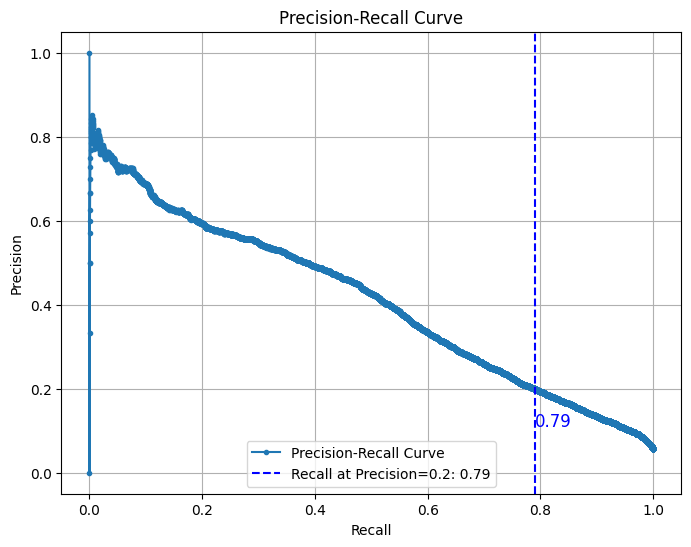

In [7]:
# Calculate precision, recall, thresholds matrix, and plot them out. 
# Adding a vertical line shows value of recall when precision is 0.2.
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# Find the index where precision is closet to 0.2
idx = np.argmin(np.abs(precision - 0.2))
recall_at_precision_02 = recall[idx]
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.axvline(x=recall_at_precision_02, color='b', linestyle='--', label=f'Recall at Precision=0.2: {recall_at_precision_02:.2f}')
plt.text(recall_at_precision_02, 0.1, f'{recall_at_precision_02:.2f}', color='b', fontsize=12, verticalalignment='bottom')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Print average precision score
score

0.40880878188842584

True


,feature,importance_mean,importance_std
6,HadAngina,0.250181,0.002110
1,Sex,0.027763,0.001330
25,AgeCategory,0.019599,0.001306
7,HadStroke,0.018683,0.000883
2,GeneralHealth,0.010167,0.001457
5,RemovedTeeth,0.008244,0.000705
21,SmokerStatus,0.005981,0.000643
14,HadDiabetes,0.005567,0.001001
23,ChestScan,0.003126,0.000346
0,State,0.001923,0.001018


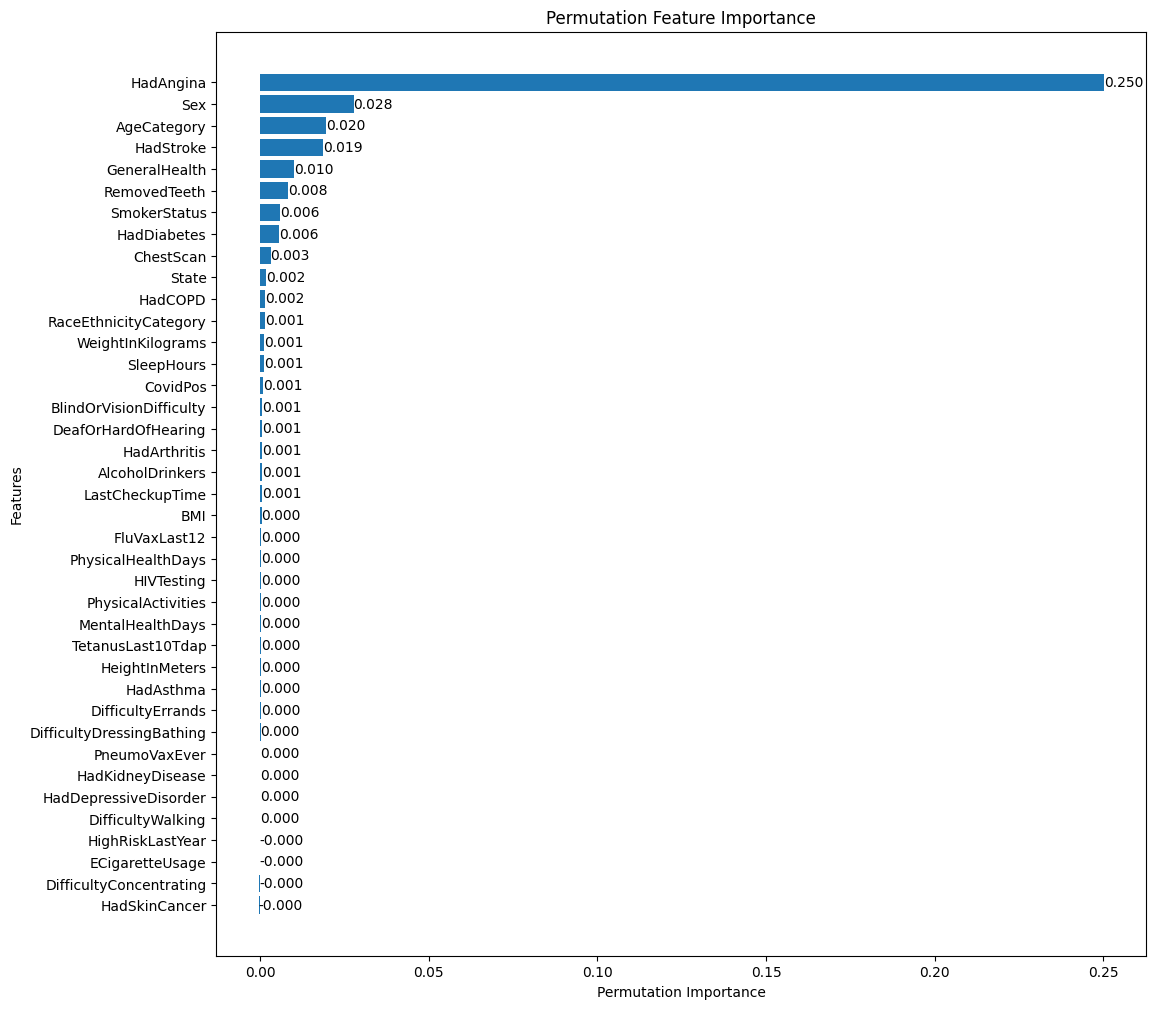

In [9]:
# Wrap model into sklearn compatible class for permutation importance analysis
from sklearn.base import ClassifierMixin
class wrappedMLP(ClassifierMixin):
    def __init__(self, model):
        self.classes_ = np.array([0, 1])
        self.model = model
    def fit(self, X, y=None):
        return self
    def predict_proba(self, X):
        X_categories = torch.tensor(X[:,0:length], dtype=torch.long)
        X_numerics = torch.tensor(X[:,length:], dtype=torch.float32)
        test_ds = TensorDataset(X_categories, X_numerics)
        test_loader = DataLoader(test_ds, batch_size=study.best_params['batch_size'])
        model.eval()
        logits = []
        with torch.no_grad():
            for xcb, xnb in test_loader:
                xcb, xnb = xcb.to(device), xnb.to(device)
                logits.append(self.model(xcb, xnb))
            logits = torch.cat(logits, dim=0)
        probs = torch.sigmoid(logits).cpu().numpy()
        return np.hstack(tup=[1 - probs, probs])
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)
X_for_permutation = pd.DataFrame(data=X_test, columns=categoryFeatures+numericalFeatures)
wrap = wrappedMLP(model)
from sklearn.base import is_classifier
print(is_classifier(wrap)) 

# Permutation importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(
    estimator=wrap, 
    X=X_test, 
    y=y_test,
    n_repeats=10,
    random_state=seed,
    scoring='average_precision'
    )

# Transform results of permutation_importance to dataframe for plot and sort
df_importance = pd.DataFrame({
    "feature": categoryFeatures + numericalFeatures,
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std
})

df_importance = df_importance.sort_values(by="importance_mean", ascending=False)
display(df_importance)

# Plot a picture to visualize ferture importance
plt.figure(figsize=(12, 12))
bars = plt.barh(df_importance['feature'], df_importance['importance_mean'])
for bar in bars:
    plt.text(bar.get_width(),
             bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.3f}",
             va='center')
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
# Make most important feature show on the top
plt.gca().invert_yaxis()
plt.show()